# Object Detection For Radar

## Imports

In [16]:
import os
import re
import cv2
import glob
import time
import json
import torch
import pickle
import random
import torchvision
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from torchvision import models, transforms
from torch.nn.utils.rnn import pad_sequence
from transformers import DetrForObjectDetection
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as F
from sklearn.metrics import average_precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Data Loading

### Import config 

In [17]:
def load_config(config_path):
    
    with open(config_path, 'r') as config_file:
        content = config_file.read()
        if not content.strip():
            raise ValueError("Configuration file is empty")
        config = json.loads(content)
    return config


config_path = "/home/hawk/Desktop/objectDetection/Object_detection/configs/config.json"
config = load_config(config_path)

# all data
train_path = config["train_path"]
test_path = config["test_path"]

# example (only part 9, which is the smallest)
example_RAD_folder_path = config["example_RAD_folder_path"]
example_stereo_folder_path = config["example_stereo_folder_path"]
example_GT_folder_path = config["example_GT_folder_path"]

### Load RADDet data (or paths)

In [18]:
def load_all_data(data_path, subfolder, file_type, load_all=True):
    """
    Load data from a specified subfolder and file type

    Parameters:
    data_path (str): path of the data directory.
    subfolder (str): subfolder name.
    file_type (str): type of the files to load ('.npy', '.pickle', '.jpg').
    load_all (bool): load the data or just return file paths.

    
    for example: a folder "data" containing 3 subfolder: gt, RAD and stereo_image
    each contain 2 subfolders: part_1, part_2.
    
    This function gets the "data" path, the desires subfolder for example gt,
    and the file type we want to load from there, for example ".pickle
    
    the function returns a list containing all pickle files from gt in all parts.
    """
    loaders = {
        '.npy': np.load,
        '.pickle': lambda filepath: pickle.load(open(filepath,'rb')),
        '.jpg': Image.open
    }

    loader = loaders.get(file_type)
    if loader is None:
        raise ValueError(f"file type is unassigned or unsupported.")
    
    data = []
    data_path = os.path.join(data_path, subfolder)
    for root, subdirs, files in os.walk(data_path):
        for filename in files:
            if filename.endswith(file_type):
                filepath = os.path.join(root, filename)
                if load_all:
                    data.append(loader(filepath))
                else:
                    data.append(filepath)

    return data

### Load & Sort Path For Lazy Loading

In [19]:
train_RAD_paths = load_all_data(train_path, 'RAD', '.npy', False) 
train_GT_paths = load_all_data(train_path, 'gt', '.pickle', False)
train_stereo_paths = load_all_data(train_path, 'stereo_image', '.jpg', False)
test_RAD_paths = load_all_data(test_path, 'RAD', '.npy', False) 
test_GT_paths = load_all_data(test_path, 'gt', '.pickle', False)
test_stereo_paths = load_all_data(test_path, 'stereo_image', '.jpg', False)

In [20]:
def extract_number(path):
    filename = os.path.basename(path)
    number = re.search(r'\d+', filename).group()
    return number
print(extract_number(train_stereo_paths[0]))

003172


In [21]:
train_RAD_paths = sorted(train_RAD_paths, key=extract_number)
train_GT_paths = sorted(train_GT_paths, key=extract_number)
train_stereo_paths = sorted(train_stereo_paths, key=extract_number)
test_RAD_paths = sorted(test_RAD_paths, key=extract_number)
test_GT_paths = sorted(test_GT_paths, key=extract_number)
test_stereo_paths = sorted(test_stereo_paths, key=extract_number)

### load an example folder for data exploration

In [22]:
# Numpy files
RAD_files_paths = [os.path.join(example_RAD_folder_path, file) for file in os.listdir(example_RAD_folder_path) if file.endswith('.npy')]
example_RAD_files = [np.load(file) for file in RAD_files_paths]
print(' ---- RAD ----')
print(f'Number of RAD files loaded: {len(example_RAD_files)}')
print(f'Each RAD file is of size: {example_RAD_files[0].shape} which stands for: (Range, Azimuth, Doppler)')
print('\n')

# Ground truth files
GT_files_paths = [os.path.join(example_GT_folder_path, file) for file in os.listdir(example_GT_folder_path) if file.endswith('.pickle')]
example_GT_files = []
for file in GT_files_paths:
    with open(file, 'rb') as f:
        example_GT_files.append(pickle.load(f))
print(' ---- GT ----')
print(f'Number of GT files loaded: {len(example_GT_files)}')
print(f'Each GT file is a dict with length 3: classes, boxes and cart_boxes. An example:')
print(example_GT_files[0])
print('\n')

# Stereo image files
stereo_files_paths = [os.path.join(example_stereo_folder_path, file) for file in os.listdir(example_stereo_folder_path) if file.endswith('.jpg')]
example_stereo_files = [Image.open(file).convert('RGB') for file in stereo_files_paths]
print(' ---- Stereo ----')
print(f'Number of loaded images: {len(example_stereo_files)}')


 ---- RAD ----
Number of RAD files loaded: 126
Each RAD file is of size: (256, 256, 64) which stands for: (Range, Azimuth, Doppler)


 ---- GT ----
Number of GT files loaded: 126
Each GT file is a dict with length 3: classes, boxes and cart_boxes. An example:
{'classes': ['truck', 'car', 'car', 'car'], 'boxes': array([[177.5, 173. ,  30. ,  28. ,  51. ,  25. ],
       [202. , 217.5,  32. ,   9. ,  34. ,  17. ],
       [ 66. ,  95. ,  40.5,   5. ,   7. ,   4. ],
       [ 15.5,  89.5,  38. ,   4. ,   8. ,   5. ]]), 'cart_boxes': array([[183.5, 283.5,  30. ,  30. ],
       [218. , 290.5,  19. ,  10. ],
       [ 72.5, 206. ,   6. ,  11. ],
       [ 26.5, 183. ,   8. ,  13. ]])}


 ---- Stereo ----
Number of loaded images: 126


## RADDet Preprocessing & Custom Dataset Classes

### RADDet preprocessing functions

In [23]:
def read_and_encode_GtRD(gt_instance, rd_shape):
    x_shape, y_shape = rd_shape[1], rd_shape[0]
    boxes = gt_instance["boxes"]
    classes = gt_instance["classes"]
    new_boxes = []
    new_classes = []
    for (box, class_) in zip(boxes, classes):
        yc, xc, h, w = box[0], box[2], box[3], box[5]
        y1, y2, x1, x2 = int(yc - h / 2), int(yc + h / 2), int(xc - w / 2), int(xc + w / 2)
        if x1 < 0:
            x1 += x_shape
            box1 = [y1 , x1, y2, x_shape]
            box2 = [y1, 0, y2, x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        elif x2 >= x_shape:
            x2 -= x_shape
            box1 = [y1, x1, y2, x_shape]
            box2 = [y1, 0, y2, x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        else:
            new_boxes.append([y1 , x1, y2 , x2])
            new_classes.append(class_)
    return new_boxes, new_classes

In [24]:
def complex_to_2_channels(target_array):
    assert target_array.dtype == np.complex64
    output_array = get_magnitude(target_array)
    output_array = get_log(output_array)
    return output_array

def get_magnitude(target_array, power_order=2):
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array

def get_log(target_array, scalar=1., log_10=True):
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array

def get_sum_dim(target_array, target_axis):
    output = np.sum(target_array, axis=target_axis)
    return output

### Custom RADDet Dataset Class 1 (Eager Loading)

In [25]:
class Eager_RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset."""
    
    def __init__(self, RAD_files, GT_files, stereo_files, transform=None):
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_maps = RAD_files
        self.GT_data = GT_files
        self.stereo_data = stereo_files
        self.global_mean_log = 3.2438383
        self.global_variance_log = 6.8367246
        self.global_max_log = 10.0805629
        self.global_min_log = 0.0
    
    def __len__(self):
        return len(self.RAD_maps)
    
    def __getitem__(self, idx):
        RAD_complex = self.RAD_maps[idx]
        
        RAD_data = complex_to_2_channels(RAD_complex)
        RAD_data = (RAD_data - self.global_mean_log) / self.global_variance_log
        
        gt_instances = self.GT_data[idx]

        RD_data = get_sum_dim(RAD_data, target_axis=1)

        bboxes, classes = read_and_encode_GtRD(gt_instances, RD_data.shape)
        #seq_id = int(RAD_filename.split('/')[-2].split('_')[-1])
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            area = (xmax - xmin) * (ymax - ymin)
            objects.append({
                'bbox': [ymin, xmin, ymax, xmax],
                'label': self.classes_list.index(class_),
                'area': area,
            })
        
        image_filename = self.stereo_data[idx]
        image = plt.imread(image_filename)


        sample = {
            'spectrum': torch.tensor(RD_data, dtype=torch.float32),
            'image': image,
            'image_filename': image_filename,
            'objects': objects,
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

### Custom RADDet Dataset Class 2 (Lazy Loading)

In [26]:
class Lazy_RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset."""
    
    def __init__(self, RAD_paths, GT_paths, stereo_paths, transform=None):
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_paths = RAD_paths
        self.GT_paths = GT_paths
        self.stereo_paths = stereo_paths
        self.global_mean_log = 3.2438383
        self.global_variance_log = 6.8367246
        self.global_max_log = 10.0805629
        self.global_min_log = 0.0
    
    def __len__(self):
        return len(self.RAD_paths)
    
    def __getitem__(self, idx):
        RAD_complex = np.load(self.RAD_paths[idx])
        RAD_data = complex_to_2_channels(RAD_complex)
        RAD_data = (RAD_data - self.global_mean_log) / self.global_variance_log
        
        with open(self.GT_paths[idx], 'rb') as file:
            gt_instances = pickle.load(file)
        RD_data = get_sum_dim(RAD_data, target_axis=1)

        bboxes, classes = read_and_encode_GtRD(gt_instances, RD_data.shape)
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            area = (xmax - xmin) * (ymax - ymin)
            objects.append({
                'bbox': [ymin, xmin, ymax, xmax],
                'label': self.classes_list.index(class_),
                'area': area,
            })
        
        image_filename = self.stereo_paths[idx]
        image = plt.imread(image_filename)


        sample = {
            'spectrum': torch.tensor(RD_data, dtype=torch.float32),
            'image': image,
            'image_filename': image_filename,
            'spectrum_filename': self.RAD_paths[idx],
            'gt_filename':self.GT_paths[idx],
            'objects': objects,
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

### DETR Dataset (Check Differences)

In [27]:
class DETR_RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset."""
    
    def __init__(self, RAD_paths, GT_paths, stereo_paths=None, transform=None):
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_paths = RAD_paths
        self.GT_paths = GT_paths
        self.global_mean_log = 3.2438383
        self.global_variance_log = 6.8367246
        self.global_max_log = 10.0805629
        self.global_min_log = 0.0
    
    def __len__(self):
        return len(self.RAD_paths)
    
    def __getitem__(self, idx):
        RAD_complex = np.load(self.RAD_paths[idx])
        RAD_data = complex_to_2_channels(RAD_complex)
        RAD_data = (RAD_data - self.global_mean_log) / self.global_variance_log
        
        with open(self.GT_paths[idx], 'rb') as file:
            gt_instances = pickle.load(file)
        RD_data = get_sum_dim(RAD_data, target_axis=1)

        bboxes, classes = read_and_encode_GtRD(gt_instances, RD_data.shape)
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            area = (xmax - xmin) * (ymax - ymin)
            objects.append({
                'bbox': [xmin, ymin, xmax, ymax],  # Note the format change for DETR
                'label': self.classes_list.index(class_),
                'area': area,
            })
        
        # Duplicate the single channel to create a 3-channel tensor
        spectrum_3ch = torch.tensor(RD_data, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
        
        sample = {
            'spectrum': spectrum_3ch,
            'objects': objects,
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

### Plot sample - check that the data is sorted and the bounding boxes makes sense

/home/hawk/Desktop/data/Raddet/raw/train/stereo_image/part_3/000001.jpg /home/hawk/Desktop/data/Raddet/raw/train/RAD/part_3/000001.npy /home/hawk/Desktop/data/Raddet/raw/train/gt/part_3/000001.pickle


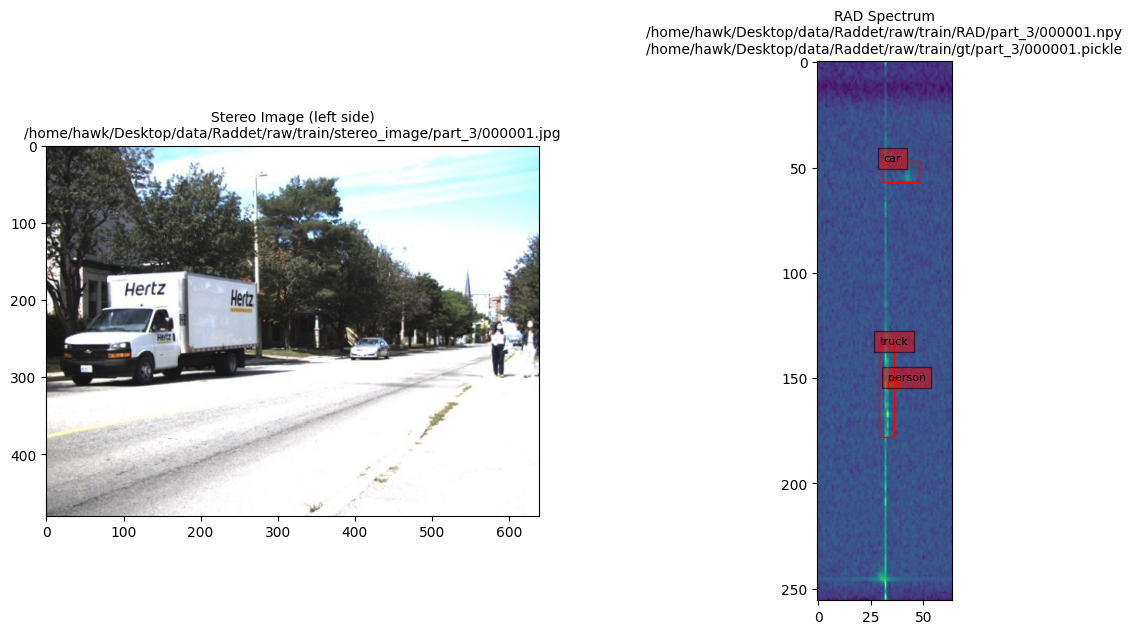

In [28]:
def plot_sample(sample, classes_list, show_side='left'):
    """
    Plots the image, spectrum, and bounding boxes from the sample, and displays filenames.
    
    Args:
        sample (dict): A sample containing 'spectrum', 'image', 'image_filename', 'spectrum_filename', 'gt_filename', and 'objects'.
        classes_list (list): List of class names.
        show_side (str): Which side of the stereo image to show ('left' or 'right').
    """
    spectrum = sample['spectrum'].numpy()
    image = np.array(sample['image'])
    objects = sample['objects']
    
    image_filename = sample['image_filename']
    spectrum_filename = sample['spectrum_filename']
    gt_filename = sample['gt_filename']
    print(image_filename, spectrum_filename, gt_filename)
    
    # Transpose the image array if necessary
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Assume the stereo image is horizontally concatenated and split it
    height, width, _ = image.shape
    half_width = width // 2
    
    if show_side == 'left':
        image = image[:, :half_width, :]
    elif show_side == 'right':
        image = image[:, half_width:, :]
    
    # Plot the image
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Stereo Image ({show_side} side)\n{image_filename}", fontsize=10)
    
    # Plot the spectrum
    plt.subplot(1, 2, 2)
    plt.imshow(spectrum, cmap='viridis')
    plt.title(f"RAD Spectrum\n{spectrum_filename}\n{gt_filename}", fontsize=10)
    
    # Add bounding boxes to the spectrum
    ax = plt.gca()
    for obj in objects:
        bbox = obj['bbox']
        ymin, xmin, ymax, xmax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label = classes_list[obj['label']]
        plt.text(xmin, ymin, label, fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

# Example usage:
# Assuming `dataset` is an instance of RaddetDataset and `classes_list` is defined
train_dataset = Lazy_RaddetDataset(train_RAD_paths, train_GT_paths, train_stereo_paths)  # example stereo files
random_num = random.randint(0, 10)
sample = train_dataset[random_num]
plot_sample(sample, train_dataset.classes_list, show_side='left')


## Object Detection Algorithms

### Faster R-CNN Training

/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hawk/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [1/50], Iteration [0], Loss: 20.2591
Epoch [1/50], Iteration [10], Loss: 32.8139
Epoch [1/50], Iteration [20], Loss: 22.4802
Epoch [1/50], Iteration [30], Loss: 21.4767
Epoch [1/50], Iteration [40], Loss: 22.3000
Epoch [1/50], Iteration [50], Loss: 25.4137
Epoch [1/50], Iteration [60], Loss: 17.3120
Epoch [1/50], Iteration [70], Loss: 15.7291
Epoch [1/50], Iteration [80], Loss: 16.2311
Epoch [1/50], Iteration [90], Loss: 15.6885
Epoch [1/50], Iteration [100], Loss: 13.7072
Epoch [1/50], Iteration [110], Loss: 12.9948
Epoch [1/50], Iteration [120], Loss: 14.0394
Epoch [1/50], Iteration [130], Loss: 14.5210
Epoch [1/50], Iteration [140], Loss: 17.5084
Epoch [1/50], Iteration [150], Loss: 10.7247
Epoch [1/50], Iteration [160], Loss: 4.2865
Epoch [1/50], Iteration [170], Loss: 16.2905
Epoch [1/50], Iteration [180], Loss: 12.3518
Epoch [1/50], Iteration [190], Loss: 12.1734
Epoch [1/50], Iteration [200], Loss: 4.9200
Epoch [1/50], Iteration [210], Loss: 14.9514
Epoch [1/50], Iteration

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 3]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 340]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 10]
Epoch [1/50] completed with mAP: 0.0000
Epoch [2/50], Iteration [0], Loss: 9.9326


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [2/50], Iteration [10], Loss: 13.1980
Epoch [2/50], Iteration [20], Loss: 9.4051
Epoch [2/50], Iteration [30], Loss: 6.3301
Epoch [2/50], Iteration [40], Loss: 11.8152
Epoch [2/50], Iteration [50], Loss: 4.8442
Epoch [2/50], Iteration [60], Loss: 13.0366
Epoch [2/50], Iteration [70], Loss: 3.9817
Epoch [2/50], Iteration [80], Loss: 3.9618
Epoch [2/50], Iteration [90], Loss: 7.4284
Epoch [2/50], Iteration [100], Loss: 7.3911
Epoch [2/50], Iteration [110], Loss: 7.3001
Epoch [2/50], Iteration [120], Loss: 12.5372
Epoch [2/50], Iteration [130], Loss: 9.2811
Epoch [2/50], Iteration [140], Loss: 10.9509
Epoch [2/50], Iteration [150], Loss: 9.1757
Epoch [2/50], Iteration [160], Loss: 15.3444
Epoch [2/50], Iteration [170], Loss: 8.2924
Epoch [2/50], Iteration [180], Loss: 9.7518
Epoch [2/50], Iteration [190], Loss: 3.7243
Epoch [2/50], Iteration [200], Loss: 3.0225
Epoch [2/50], Iteration [210], Loss: 15.9064
Epoch [2/50], Iteration [220], Loss: 8.3599
Epoch [2/50], Iteration [230], Los

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 982]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 218]
Epoch [2/50] completed with mAP: 0.0000
Epoch [3/50], Iteration [0], Loss: 7.6551


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [3/50], Iteration [10], Loss: 9.5918
Epoch [3/50], Iteration [20], Loss: 11.6598
Epoch [3/50], Iteration [30], Loss: 3.6943
Epoch [3/50], Iteration [40], Loss: 2.1442
Epoch [3/50], Iteration [50], Loss: 4.5607
Epoch [3/50], Iteration [60], Loss: 6.2068
Epoch [3/50], Iteration [70], Loss: 3.6888
Epoch [3/50], Iteration [80], Loss: 10.0531
Epoch [3/50], Iteration [90], Loss: 13.2393
Epoch [3/50], Iteration [100], Loss: 16.8381
Epoch [3/50], Iteration [110], Loss: 13.7786
Epoch [3/50], Iteration [120], Loss: 15.7013
Epoch [3/50], Iteration [130], Loss: 13.5121
Epoch [3/50], Iteration [140], Loss: 9.0011
Epoch [3/50], Iteration [150], Loss: 12.0319
Epoch [3/50], Iteration [160], Loss: 14.6406
Epoch [3/50], Iteration [170], Loss: 7.8021
Epoch [3/50], Iteration [180], Loss: 5.0889
Epoch [3/50], Iteration [190], Loss: 5.6704
Epoch [3/50], Iteration [200], Loss: 5.2216
Epoch [3/50], Iteration [210], Loss: 9.0912
Epoch [3/50], Iteration [220], Loss: 6.7593
Epoch [3/50], Iteration [230], L

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 14]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 4]
Epoch [3/50] completed with mAP: 0.0000
Epoch [4/50], Iteration [0], Loss: 9.9976


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [4/50], Iteration [10], Loss: 8.7877
Epoch [4/50], Iteration [20], Loss: 11.8821
Epoch [4/50], Iteration [30], Loss: 13.5502
Epoch [4/50], Iteration [40], Loss: 10.2218
Epoch [4/50], Iteration [50], Loss: 15.1227
Epoch [4/50], Iteration [60], Loss: 5.8357
Epoch [4/50], Iteration [70], Loss: 7.4698
Epoch [4/50], Iteration [80], Loss: 9.8897
Epoch [4/50], Iteration [90], Loss: 8.1691
Epoch [4/50], Iteration [100], Loss: 15.6155
Epoch [4/50], Iteration [110], Loss: 10.2539
Epoch [4/50], Iteration [120], Loss: 12.2969
Epoch [4/50], Iteration [130], Loss: 10.7293
Epoch [4/50], Iteration [140], Loss: 11.7822
Epoch [4/50], Iteration [150], Loss: 13.5205
Epoch [4/50], Iteration [160], Loss: 18.5600
Epoch [4/50], Iteration [170], Loss: 9.4755
Epoch [4/50], Iteration [180], Loss: 4.7799
Epoch [4/50], Iteration [190], Loss: 13.7377
Epoch [4/50], Iteration [200], Loss: 13.3061
Epoch [4/50], Iteration [210], Loss: 10.4476
Epoch [4/50], Iteration [220], Loss: 7.5043
Epoch [4/50], Iteration [23

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 53]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 16]
Epoch [4/50] completed with mAP: 0.0000
Epoch [5/50], Iteration [0], Loss: 8.2234


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [5/50], Iteration [10], Loss: 5.9640
Epoch [5/50], Iteration [20], Loss: 7.5289
Epoch [5/50], Iteration [30], Loss: 3.7779
Epoch [5/50], Iteration [40], Loss: 7.5492
Epoch [5/50], Iteration [50], Loss: 9.1886
Epoch [5/50], Iteration [60], Loss: 11.2484
Epoch [5/50], Iteration [70], Loss: 11.1017
Epoch [5/50], Iteration [80], Loss: 12.4361
Epoch [5/50], Iteration [90], Loss: 5.4092
Epoch [5/50], Iteration [100], Loss: 4.9390
Epoch [5/50], Iteration [110], Loss: 17.3761
Epoch [5/50], Iteration [120], Loss: 4.5752
Epoch [5/50], Iteration [130], Loss: 10.8687
Epoch [5/50], Iteration [140], Loss: 8.7327
Epoch [5/50], Iteration [150], Loss: 15.7024
Epoch [5/50], Iteration [160], Loss: 12.1639
Epoch [5/50], Iteration [170], Loss: 7.6886
Epoch [5/50], Iteration [180], Loss: 8.9517
Epoch [5/50], Iteration [190], Loss: 8.6766
Epoch [5/50], Iteration [200], Loss: 8.0787
Epoch [5/50], Iteration [210], Loss: 7.3070
Epoch [5/50], Iteration [220], Loss: 7.4046
Epoch [5/50], Iteration [230], Los

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 1]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 42]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 1]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 16]
Epoch [5/50] completed with mAP: 0.0000
Epoch [6/50], Iteration [0], Loss: 6.8996


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [6/50], Iteration [10], Loss: 19.7906
Epoch [6/50], Iteration [20], Loss: 19.1632
Epoch [6/50], Iteration [30], Loss: 7.6879
Epoch [6/50], Iteration [40], Loss: 8.5449
Epoch [6/50], Iteration [50], Loss: 10.6714
Epoch [6/50], Iteration [60], Loss: 7.5882
Epoch [6/50], Iteration [70], Loss: 4.8756
Epoch [6/50], Iteration [80], Loss: 11.2847
Epoch [6/50], Iteration [90], Loss: 4.6291
Epoch [6/50], Iteration [100], Loss: 14.4666
Epoch [6/50], Iteration [110], Loss: 9.9977
Epoch [6/50], Iteration [120], Loss: 5.0055
Epoch [6/50], Iteration [130], Loss: 17.8212
Epoch [6/50], Iteration [140], Loss: 10.8672
Epoch [6/50], Iteration [150], Loss: 13.6564
Epoch [6/50], Iteration [160], Loss: 9.8730
Epoch [6/50], Iteration [170], Loss: 7.2457
Epoch [6/50], Iteration [180], Loss: 4.3426
Epoch [6/50], Iteration [190], Loss: 7.5929
Epoch [6/50], Iteration [200], Loss: 10.5517
Epoch [6/50], Iteration [210], Loss: 12.9401
Epoch [6/50], Iteration [220], Loss: 11.8283
Epoch [6/50], Iteration [230],

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 10]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 376]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 10]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 148]
Epoch [6/50] completed with mAP: 0.0000
Epoch [7/50], Iteration [0], Loss: 10.4971


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [7/50], Iteration [10], Loss: 4.9241
Epoch [7/50], Iteration [20], Loss: 10.7036
Epoch [7/50], Iteration [30], Loss: 1.5704
Epoch [7/50], Iteration [40], Loss: 13.1992
Epoch [7/50], Iteration [50], Loss: 12.6714
Epoch [7/50], Iteration [60], Loss: 9.7805
Epoch [7/50], Iteration [70], Loss: 3.7333
Epoch [7/50], Iteration [80], Loss: 6.0003
Epoch [7/50], Iteration [90], Loss: 8.5006
Epoch [7/50], Iteration [100], Loss: 5.7814
Epoch [7/50], Iteration [110], Loss: 15.1177
Epoch [7/50], Iteration [120], Loss: 8.6138
Epoch [7/50], Iteration [130], Loss: 15.4888
Epoch [7/50], Iteration [140], Loss: 9.2234
Epoch [7/50], Iteration [150], Loss: 5.3763
Epoch [7/50], Iteration [160], Loss: 6.2669
Epoch [7/50], Iteration [170], Loss: 3.2566
Epoch [7/50], Iteration [180], Loss: 7.8813
Epoch [7/50], Iteration [190], Loss: 6.0892
Epoch [7/50], Iteration [200], Loss: 10.7724
Epoch [7/50], Iteration [210], Loss: 7.9031
Epoch [7/50], Iteration [220], Loss: 6.6976
Epoch [7/50], Iteration [230], Loss

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 72]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 4]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 24]
Epoch [7/50] completed with mAP: 0.0000
Epoch [8/50], Iteration [0], Loss: 9.0941


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [8/50], Iteration [10], Loss: 7.3276
Epoch [8/50], Iteration [20], Loss: 4.7889
Epoch [8/50], Iteration [30], Loss: 15.8732
Epoch [8/50], Iteration [40], Loss: 10.7942
Epoch [8/50], Iteration [50], Loss: 4.4946
Epoch [8/50], Iteration [60], Loss: 8.8764
Epoch [8/50], Iteration [70], Loss: 6.3632
Epoch [8/50], Iteration [80], Loss: 15.6015
Epoch [8/50], Iteration [90], Loss: 11.2002
Epoch [8/50], Iteration [100], Loss: 11.6816
Epoch [8/50], Iteration [110], Loss: 10.7591
Epoch [8/50], Iteration [120], Loss: 11.6461
Epoch [8/50], Iteration [130], Loss: 11.0640
Epoch [8/50], Iteration [140], Loss: 12.7603
Epoch [8/50], Iteration [150], Loss: 9.3810
Epoch [8/50], Iteration [160], Loss: 10.8234
Epoch [8/50], Iteration [170], Loss: 13.9333
Epoch [8/50], Iteration [180], Loss: 8.2199
Epoch [8/50], Iteration [190], Loss: 10.4994
Epoch [8/50], Iteration [200], Loss: 8.2692
Epoch [8/50], Iteration [210], Loss: 13.3111
Epoch [8/50], Iteration [220], Loss: 9.3776
Epoch [8/50], Iteration [230

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 87]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 1]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 35]
Epoch [8/50] completed with mAP: 0.0000
Epoch [9/50], Iteration [0], Loss: 6.1177


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [9/50], Iteration [10], Loss: 8.0776
Epoch [9/50], Iteration [20], Loss: 7.2803
Epoch [9/50], Iteration [30], Loss: 7.2046
Epoch [9/50], Iteration [40], Loss: 5.1960
Epoch [9/50], Iteration [50], Loss: 4.0531
Epoch [9/50], Iteration [60], Loss: 8.7495
Epoch [9/50], Iteration [70], Loss: 2.9690
Epoch [9/50], Iteration [80], Loss: 10.3649
Epoch [9/50], Iteration [90], Loss: 8.1174
Epoch [9/50], Iteration [100], Loss: 10.6631
Epoch [9/50], Iteration [110], Loss: 10.3457
Epoch [9/50], Iteration [120], Loss: 11.9605
Epoch [9/50], Iteration [130], Loss: 7.2865
Epoch [9/50], Iteration [140], Loss: 4.1030
Epoch [9/50], Iteration [150], Loss: 8.3662
Epoch [9/50], Iteration [160], Loss: 7.5686
Epoch [9/50], Iteration [170], Loss: 7.2821
Epoch [9/50], Iteration [180], Loss: 14.3332
Epoch [9/50], Iteration [190], Loss: 2.0409
Epoch [9/50], Iteration [200], Loss: 8.0501
Epoch [9/50], Iteration [210], Loss: 14.2519
Epoch [9/50], Iteration [220], Loss: 9.8760
Epoch [9/50], Iteration [230], Loss

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 71]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 1]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [9/50] completed with mAP: 0.0000
Epoch [10/50], Iteration [0], Loss: 12.4870


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [10/50], Iteration [10], Loss: 9.0481
Epoch [10/50], Iteration [20], Loss: 15.8540
Epoch [10/50], Iteration [30], Loss: 16.1288
Epoch [10/50], Iteration [40], Loss: 11.8338
Epoch [10/50], Iteration [50], Loss: 3.0817
Epoch [10/50], Iteration [60], Loss: 9.2620
Epoch [10/50], Iteration [70], Loss: 14.0815
Epoch [10/50], Iteration [80], Loss: 12.3359
Epoch [10/50], Iteration [90], Loss: 5.8630
Epoch [10/50], Iteration [100], Loss: 13.9346
Epoch [10/50], Iteration [110], Loss: 3.3923
Epoch [10/50], Iteration [120], Loss: 1.9397
Epoch [10/50], Iteration [130], Loss: 10.8849
Epoch [10/50], Iteration [140], Loss: 9.7726
Epoch [10/50], Iteration [150], Loss: 9.3739
Epoch [10/50], Iteration [160], Loss: 11.7268
Epoch [10/50], Iteration [170], Loss: 5.4078
Epoch [10/50], Iteration [180], Loss: 3.8617
Epoch [10/50], Iteration [190], Loss: 10.3954
Epoch [10/50], Iteration [200], Loss: 12.9903
Epoch [10/50], Iteration [210], Loss: 11.5750
Epoch [10/50], Iteration [220], Loss: 12.9981
Epoch [

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 72]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 27]
Epoch [10/50] completed with mAP: 0.0000
Epoch [11/50], Iteration [0], Loss: 11.8341


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [11/50], Iteration [10], Loss: 10.4983
Epoch [11/50], Iteration [20], Loss: 6.5630
Epoch [11/50], Iteration [30], Loss: 7.7521
Epoch [11/50], Iteration [40], Loss: 9.8134
Epoch [11/50], Iteration [50], Loss: 8.6813
Epoch [11/50], Iteration [60], Loss: 2.6387
Epoch [11/50], Iteration [70], Loss: 13.8720
Epoch [11/50], Iteration [80], Loss: 14.2600
Epoch [11/50], Iteration [90], Loss: 10.1014
Epoch [11/50], Iteration [100], Loss: 14.6802
Epoch [11/50], Iteration [110], Loss: 12.6586
Epoch [11/50], Iteration [120], Loss: 10.1182
Epoch [11/50], Iteration [130], Loss: 9.1133
Epoch [11/50], Iteration [140], Loss: 3.8327
Epoch [11/50], Iteration [150], Loss: 8.2307
Epoch [11/50], Iteration [160], Loss: 10.1668
Epoch [11/50], Iteration [170], Loss: 18.3119
Epoch [11/50], Iteration [180], Loss: 10.4223
Epoch [11/50], Iteration [190], Loss: 1.7708
Epoch [11/50], Iteration [200], Loss: 12.3258
Epoch [11/50], Iteration [210], Loss: 4.8858
Epoch [11/50], Iteration [220], Loss: 8.2443
Epoch [1

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 71]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [11/50] completed with mAP: 0.0000
Epoch [12/50], Iteration [0], Loss: 3.9323


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [12/50], Iteration [10], Loss: 7.7412
Epoch [12/50], Iteration [20], Loss: 6.9537
Epoch [12/50], Iteration [30], Loss: 9.1818
Epoch [12/50], Iteration [40], Loss: 15.8405
Epoch [12/50], Iteration [50], Loss: 18.9221
Epoch [12/50], Iteration [60], Loss: 8.0331
Epoch [12/50], Iteration [70], Loss: 4.7341
Epoch [12/50], Iteration [80], Loss: 1.8355
Epoch [12/50], Iteration [90], Loss: 4.2588
Epoch [12/50], Iteration [100], Loss: 4.9891
Epoch [12/50], Iteration [110], Loss: 5.3513
Epoch [12/50], Iteration [120], Loss: 13.4662
Epoch [12/50], Iteration [130], Loss: 9.8622
Epoch [12/50], Iteration [140], Loss: 16.9770
Epoch [12/50], Iteration [150], Loss: 6.7853
Epoch [12/50], Iteration [160], Loss: 11.3215
Epoch [12/50], Iteration [170], Loss: 12.5286
Epoch [12/50], Iteration [180], Loss: 5.6842
Epoch [12/50], Iteration [190], Loss: 11.9279
Epoch [12/50], Iteration [200], Loss: 8.0421
Epoch [12/50], Iteration [210], Loss: 7.8575
Epoch [12/50], Iteration [220], Loss: 10.9038
Epoch [12/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 69]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [12/50] completed with mAP: 0.0000
Epoch [13/50], Iteration [0], Loss: 6.3634


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [13/50], Iteration [10], Loss: 7.5554
Epoch [13/50], Iteration [20], Loss: 8.9823
Epoch [13/50], Iteration [30], Loss: 14.1705
Epoch [13/50], Iteration [40], Loss: 6.1304
Epoch [13/50], Iteration [50], Loss: 7.9413
Epoch [13/50], Iteration [60], Loss: 7.9825
Epoch [13/50], Iteration [70], Loss: 9.9192
Epoch [13/50], Iteration [80], Loss: 14.6907
Epoch [13/50], Iteration [90], Loss: 3.3468
Epoch [13/50], Iteration [100], Loss: 7.4446
Epoch [13/50], Iteration [110], Loss: 7.3579
Epoch [13/50], Iteration [120], Loss: 3.4162
Epoch [13/50], Iteration [130], Loss: 10.3339
Epoch [13/50], Iteration [140], Loss: 7.8963
Epoch [13/50], Iteration [150], Loss: 5.2431
Epoch [13/50], Iteration [160], Loss: 10.6955
Epoch [13/50], Iteration [170], Loss: 12.8074
Epoch [13/50], Iteration [180], Loss: 3.6970
Epoch [13/50], Iteration [190], Loss: 4.1304
Epoch [13/50], Iteration [200], Loss: 16.1968
Epoch [13/50], Iteration [210], Loss: 20.2276
Epoch [13/50], Iteration [220], Loss: 5.3521
Epoch [13/50

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [13/50] completed with mAP: 0.0000
Epoch [14/50], Iteration [0], Loss: 18.4779


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [14/50], Iteration [10], Loss: 4.1926
Epoch [14/50], Iteration [20], Loss: 13.6089
Epoch [14/50], Iteration [30], Loss: 6.0049
Epoch [14/50], Iteration [40], Loss: 14.8257
Epoch [14/50], Iteration [50], Loss: 18.9740
Epoch [14/50], Iteration [60], Loss: 7.7242
Epoch [14/50], Iteration [70], Loss: 8.5975
Epoch [14/50], Iteration [80], Loss: 7.4701
Epoch [14/50], Iteration [90], Loss: 3.1799
Epoch [14/50], Iteration [100], Loss: 14.7071
Epoch [14/50], Iteration [110], Loss: 3.8782
Epoch [14/50], Iteration [120], Loss: 10.2306
Epoch [14/50], Iteration [130], Loss: 7.5688
Epoch [14/50], Iteration [140], Loss: 8.2138
Epoch [14/50], Iteration [150], Loss: 4.0312
Epoch [14/50], Iteration [160], Loss: 10.2918
Epoch [14/50], Iteration [170], Loss: 8.1384
Epoch [14/50], Iteration [180], Loss: 11.3374
Epoch [14/50], Iteration [190], Loss: 8.5012
Epoch [14/50], Iteration [200], Loss: 10.0074
Epoch [14/50], Iteration [210], Loss: 7.8162
Epoch [14/50], Iteration [220], Loss: 12.7229
Epoch [14/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [14/50] completed with mAP: 0.0000
Epoch [15/50], Iteration [0], Loss: 13.0227


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [15/50], Iteration [10], Loss: 16.2102
Epoch [15/50], Iteration [20], Loss: 12.8360
Epoch [15/50], Iteration [30], Loss: 16.0020
Epoch [15/50], Iteration [40], Loss: 12.7647
Epoch [15/50], Iteration [50], Loss: 6.3088
Epoch [15/50], Iteration [60], Loss: 4.3745
Epoch [15/50], Iteration [70], Loss: 9.1818
Epoch [15/50], Iteration [80], Loss: 7.5824
Epoch [15/50], Iteration [90], Loss: 4.6380
Epoch [15/50], Iteration [100], Loss: 4.1837
Epoch [15/50], Iteration [110], Loss: 3.3502
Epoch [15/50], Iteration [120], Loss: 5.9127
Epoch [15/50], Iteration [130], Loss: 3.7131
Epoch [15/50], Iteration [140], Loss: 11.4808
Epoch [15/50], Iteration [150], Loss: 9.8693
Epoch [15/50], Iteration [160], Loss: 7.1316
Epoch [15/50], Iteration [170], Loss: 8.6396
Epoch [15/50], Iteration [180], Loss: 9.6666
Epoch [15/50], Iteration [190], Loss: 6.1967
Epoch [15/50], Iteration [200], Loss: 7.4195
Epoch [15/50], Iteration [210], Loss: 8.7272
Epoch [15/50], Iteration [220], Loss: 8.0099
Epoch [15/50],

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [15/50] completed with mAP: 0.0000
Epoch [16/50], Iteration [0], Loss: 8.9997


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [16/50], Iteration [10], Loss: 14.7983
Epoch [16/50], Iteration [20], Loss: 14.3363
Epoch [16/50], Iteration [30], Loss: 7.2125
Epoch [16/50], Iteration [40], Loss: 11.4741
Epoch [16/50], Iteration [50], Loss: 13.5985
Epoch [16/50], Iteration [60], Loss: 7.6054
Epoch [16/50], Iteration [70], Loss: 7.4941
Epoch [16/50], Iteration [80], Loss: 7.4154
Epoch [16/50], Iteration [90], Loss: 7.3293
Epoch [16/50], Iteration [100], Loss: 5.8296
Epoch [16/50], Iteration [110], Loss: 12.5818
Epoch [16/50], Iteration [120], Loss: 7.0541
Epoch [16/50], Iteration [130], Loss: 11.0567
Epoch [16/50], Iteration [140], Loss: 12.9800
Epoch [16/50], Iteration [150], Loss: 5.2325
Epoch [16/50], Iteration [160], Loss: 8.6221
Epoch [16/50], Iteration [170], Loss: 9.6730
Epoch [16/50], Iteration [180], Loss: 8.3149
Epoch [16/50], Iteration [190], Loss: 6.2260
Epoch [16/50], Iteration [200], Loss: 8.4338
Epoch [16/50], Iteration [210], Loss: 15.7240
Epoch [16/50], Iteration [220], Loss: 8.2830
Epoch [16/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 71]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 27]
Epoch [16/50] completed with mAP: 0.0000
Epoch [17/50], Iteration [0], Loss: 13.9473


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [17/50], Iteration [10], Loss: 8.8034
Epoch [17/50], Iteration [20], Loss: 15.0648
Epoch [17/50], Iteration [30], Loss: 10.4377
Epoch [17/50], Iteration [40], Loss: 11.1225
Epoch [17/50], Iteration [50], Loss: 5.6078
Epoch [17/50], Iteration [60], Loss: 10.9611
Epoch [17/50], Iteration [70], Loss: 15.3390
Epoch [17/50], Iteration [80], Loss: 8.3693
Epoch [17/50], Iteration [90], Loss: 8.7229
Epoch [17/50], Iteration [100], Loss: 8.3708
Epoch [17/50], Iteration [110], Loss: 8.8548
Epoch [17/50], Iteration [120], Loss: 12.3060
Epoch [17/50], Iteration [130], Loss: 13.0417
Epoch [17/50], Iteration [140], Loss: 16.4421
Epoch [17/50], Iteration [150], Loss: 9.2002
Epoch [17/50], Iteration [160], Loss: 5.1570
Epoch [17/50], Iteration [170], Loss: 6.5670
Epoch [17/50], Iteration [180], Loss: 10.8895
Epoch [17/50], Iteration [190], Loss: 5.8631
Epoch [17/50], Iteration [200], Loss: 4.7077
Epoch [17/50], Iteration [210], Loss: 9.6713
Epoch [17/50], Iteration [220], Loss: 6.5756
Epoch [17/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [17/50] completed with mAP: 0.0000
Epoch [18/50], Iteration [0], Loss: 8.8523


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [18/50], Iteration [10], Loss: 7.3969
Epoch [18/50], Iteration [20], Loss: 7.0430
Epoch [18/50], Iteration [30], Loss: 18.6661
Epoch [18/50], Iteration [40], Loss: 10.8424
Epoch [18/50], Iteration [50], Loss: 8.4347
Epoch [18/50], Iteration [60], Loss: 12.5660
Epoch [18/50], Iteration [70], Loss: 11.3887
Epoch [18/50], Iteration [80], Loss: 12.2086
Epoch [18/50], Iteration [90], Loss: 2.1357
Epoch [18/50], Iteration [100], Loss: 2.7450
Epoch [18/50], Iteration [110], Loss: 10.1393
Epoch [18/50], Iteration [120], Loss: 13.0192
Epoch [18/50], Iteration [130], Loss: 3.6161
Epoch [18/50], Iteration [140], Loss: 13.7236
Epoch [18/50], Iteration [150], Loss: 8.2752
Epoch [18/50], Iteration [160], Loss: 8.8678
Epoch [18/50], Iteration [170], Loss: 8.7848
Epoch [18/50], Iteration [180], Loss: 5.1734
Epoch [18/50], Iteration [190], Loss: 5.1364
Epoch [18/50], Iteration [200], Loss: 8.2482
Epoch [18/50], Iteration [210], Loss: 11.1421
Epoch [18/50], Iteration [220], Loss: 13.4888
Epoch [18

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [18/50] completed with mAP: 0.0000
Epoch [19/50], Iteration [0], Loss: 4.5725


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [19/50], Iteration [10], Loss: 10.4571
Epoch [19/50], Iteration [20], Loss: 8.5506
Epoch [19/50], Iteration [30], Loss: 8.3078
Epoch [19/50], Iteration [40], Loss: 4.7962
Epoch [19/50], Iteration [50], Loss: 6.0394
Epoch [19/50], Iteration [60], Loss: 7.2323
Epoch [19/50], Iteration [70], Loss: 9.4295
Epoch [19/50], Iteration [80], Loss: 15.1779
Epoch [19/50], Iteration [90], Loss: 9.8344
Epoch [19/50], Iteration [100], Loss: 8.8514
Epoch [19/50], Iteration [110], Loss: 2.8429
Epoch [19/50], Iteration [120], Loss: 5.6551
Epoch [19/50], Iteration [130], Loss: 4.5795
Epoch [19/50], Iteration [140], Loss: 6.4452
Epoch [19/50], Iteration [150], Loss: 8.9770
Epoch [19/50], Iteration [160], Loss: 10.5546
Epoch [19/50], Iteration [170], Loss: 3.0357
Epoch [19/50], Iteration [180], Loss: 9.9088
Epoch [19/50], Iteration [190], Loss: 6.2708
Epoch [19/50], Iteration [200], Loss: 1.9893
Epoch [19/50], Iteration [210], Loss: 13.8641
Epoch [19/50], Iteration [220], Loss: 4.6591
Epoch [19/50], 

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [19/50] completed with mAP: 0.0000
Epoch [20/50], Iteration [0], Loss: 14.8747


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [20/50], Iteration [10], Loss: 3.8912
Epoch [20/50], Iteration [20], Loss: 4.0472
Epoch [20/50], Iteration [30], Loss: 5.7419
Epoch [20/50], Iteration [40], Loss: 3.5484
Epoch [20/50], Iteration [50], Loss: 10.2219
Epoch [20/50], Iteration [60], Loss: 9.8372
Epoch [20/50], Iteration [70], Loss: 15.8239
Epoch [20/50], Iteration [80], Loss: 4.0330
Epoch [20/50], Iteration [90], Loss: 10.2615
Epoch [20/50], Iteration [100], Loss: 7.5831
Epoch [20/50], Iteration [110], Loss: 6.3394
Epoch [20/50], Iteration [120], Loss: 13.1967
Epoch [20/50], Iteration [130], Loss: 8.3411
Epoch [20/50], Iteration [140], Loss: 4.2525
Epoch [20/50], Iteration [150], Loss: 10.8296
Epoch [20/50], Iteration [160], Loss: 10.4662
Epoch [20/50], Iteration [170], Loss: 13.8078
Epoch [20/50], Iteration [180], Loss: 5.2691
Epoch [20/50], Iteration [190], Loss: 6.5385
Epoch [20/50], Iteration [200], Loss: 8.4423
Epoch [20/50], Iteration [210], Loss: 8.2343
Epoch [20/50], Iteration [220], Loss: 10.6306
Epoch [20/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 6]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [20/50] completed with mAP: 0.0000
Epoch [21/50], Iteration [0], Loss: 10.0303


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [21/50], Iteration [10], Loss: 7.5330
Epoch [21/50], Iteration [20], Loss: 19.7902
Epoch [21/50], Iteration [30], Loss: 6.9794
Epoch [21/50], Iteration [40], Loss: 4.4981
Epoch [21/50], Iteration [50], Loss: 13.0075
Epoch [21/50], Iteration [60], Loss: 12.1170
Epoch [21/50], Iteration [70], Loss: 9.9668
Epoch [21/50], Iteration [80], Loss: 7.4207
Epoch [21/50], Iteration [90], Loss: 8.5653
Epoch [21/50], Iteration [100], Loss: 11.3435
Epoch [21/50], Iteration [110], Loss: 9.9943
Epoch [21/50], Iteration [120], Loss: 10.3190
Epoch [21/50], Iteration [130], Loss: 9.4448
Epoch [21/50], Iteration [140], Loss: 8.2621
Epoch [21/50], Iteration [150], Loss: 4.1981
Epoch [21/50], Iteration [160], Loss: 11.0983
Epoch [21/50], Iteration [170], Loss: 1.9753
Epoch [21/50], Iteration [180], Loss: 11.1114
Epoch [21/50], Iteration [190], Loss: 13.1394
Epoch [21/50], Iteration [200], Loss: 8.6916
Epoch [21/50], Iteration [210], Loss: 7.4738
Epoch [21/50], Iteration [220], Loss: 10.7063
Epoch [21/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [21/50] completed with mAP: 0.0000
Epoch [22/50], Iteration [0], Loss: 4.6031


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [22/50], Iteration [10], Loss: 11.0976
Epoch [22/50], Iteration [20], Loss: 10.0770
Epoch [22/50], Iteration [30], Loss: 9.7445
Epoch [22/50], Iteration [40], Loss: 13.0312
Epoch [22/50], Iteration [50], Loss: 17.3353
Epoch [22/50], Iteration [60], Loss: 4.3285
Epoch [22/50], Iteration [70], Loss: 7.2310
Epoch [22/50], Iteration [80], Loss: 6.1533
Epoch [22/50], Iteration [90], Loss: 13.9582
Epoch [22/50], Iteration [100], Loss: 8.3162
Epoch [22/50], Iteration [110], Loss: 8.2436
Epoch [22/50], Iteration [120], Loss: 10.3403
Epoch [22/50], Iteration [130], Loss: 1.9967
Epoch [22/50], Iteration [140], Loss: 10.8216
Epoch [22/50], Iteration [150], Loss: 9.0910
Epoch [22/50], Iteration [160], Loss: 16.5787
Epoch [22/50], Iteration [170], Loss: 9.5173
Epoch [22/50], Iteration [180], Loss: 11.7246
Epoch [22/50], Iteration [190], Loss: 8.4286
Epoch [22/50], Iteration [200], Loss: 7.1306
Epoch [22/50], Iteration [210], Loss: 17.1092
Epoch [22/50], Iteration [220], Loss: 6.3901
Epoch [22

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [22/50] completed with mAP: 0.0000
Epoch [23/50], Iteration [0], Loss: 4.6607


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [23/50], Iteration [10], Loss: 7.7558
Epoch [23/50], Iteration [20], Loss: 3.1678
Epoch [23/50], Iteration [30], Loss: 10.2641
Epoch [23/50], Iteration [40], Loss: 10.8099
Epoch [23/50], Iteration [50], Loss: 8.5145
Epoch [23/50], Iteration [60], Loss: 16.1951
Epoch [23/50], Iteration [70], Loss: 9.1059
Epoch [23/50], Iteration [80], Loss: 4.4847
Epoch [23/50], Iteration [90], Loss: 5.7063
Epoch [23/50], Iteration [100], Loss: 8.0967
Epoch [23/50], Iteration [110], Loss: 10.3858
Epoch [23/50], Iteration [120], Loss: 8.0723
Epoch [23/50], Iteration [130], Loss: 10.8323
Epoch [23/50], Iteration [140], Loss: 2.7946
Epoch [23/50], Iteration [150], Loss: 8.1286
Epoch [23/50], Iteration [160], Loss: 9.9667
Epoch [23/50], Iteration [170], Loss: 9.0802
Epoch [23/50], Iteration [180], Loss: 3.8382
Epoch [23/50], Iteration [190], Loss: 8.4322
Epoch [23/50], Iteration [200], Loss: 9.7139
Epoch [23/50], Iteration [210], Loss: 10.5731
Epoch [23/50], Iteration [220], Loss: 8.5068
Epoch [23/50]

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [23/50] completed with mAP: 0.0000
Epoch [24/50], Iteration [0], Loss: 12.9369


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [24/50], Iteration [10], Loss: 3.6385
Epoch [24/50], Iteration [20], Loss: 9.9051
Epoch [24/50], Iteration [30], Loss: 4.2969
Epoch [24/50], Iteration [40], Loss: 6.9325
Epoch [24/50], Iteration [50], Loss: 8.3332
Epoch [24/50], Iteration [60], Loss: 8.0616
Epoch [24/50], Iteration [70], Loss: 13.5013
Epoch [24/50], Iteration [80], Loss: 5.0589
Epoch [24/50], Iteration [90], Loss: 9.5653
Epoch [24/50], Iteration [100], Loss: 12.0771
Epoch [24/50], Iteration [110], Loss: 2.7415
Epoch [24/50], Iteration [120], Loss: 10.3336
Epoch [24/50], Iteration [130], Loss: 9.9422
Epoch [24/50], Iteration [140], Loss: 10.5429
Epoch [24/50], Iteration [150], Loss: 8.0467
Epoch [24/50], Iteration [160], Loss: 6.4423
Epoch [24/50], Iteration [170], Loss: 12.3688
Epoch [24/50], Iteration [180], Loss: 5.4492
Epoch [24/50], Iteration [190], Loss: 10.8432
Epoch [24/50], Iteration [200], Loss: 5.8389
Epoch [24/50], Iteration [210], Loss: 17.1632
Epoch [24/50], Iteration [220], Loss: 1.6575
Epoch [24/50

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [24/50] completed with mAP: 0.0000
Epoch [25/50], Iteration [0], Loss: 5.8944


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [25/50], Iteration [10], Loss: 7.2446
Epoch [25/50], Iteration [20], Loss: 9.8943
Epoch [25/50], Iteration [30], Loss: 15.3985
Epoch [25/50], Iteration [40], Loss: 5.3167
Epoch [25/50], Iteration [50], Loss: 3.1740
Epoch [25/50], Iteration [60], Loss: 14.6202
Epoch [25/50], Iteration [70], Loss: 15.1970
Epoch [25/50], Iteration [80], Loss: 8.4700
Epoch [25/50], Iteration [90], Loss: 9.4052
Epoch [25/50], Iteration [100], Loss: 6.6499
Epoch [25/50], Iteration [110], Loss: 6.5767
Epoch [25/50], Iteration [120], Loss: 7.9338
Epoch [25/50], Iteration [130], Loss: 15.9645
Epoch [25/50], Iteration [140], Loss: 6.4033
Epoch [25/50], Iteration [150], Loss: 7.5260
Epoch [25/50], Iteration [160], Loss: 4.5316
Epoch [25/50], Iteration [170], Loss: 8.6993
Epoch [25/50], Iteration [180], Loss: 12.7950
Epoch [25/50], Iteration [190], Loss: 15.5119
Epoch [25/50], Iteration [200], Loss: 8.0360
Epoch [25/50], Iteration [210], Loss: 10.6773
Epoch [25/50], Iteration [220], Loss: 15.1706
Epoch [25/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [25/50] completed with mAP: 0.0000
Epoch [26/50], Iteration [0], Loss: 10.0705


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [26/50], Iteration [10], Loss: 14.5511
Epoch [26/50], Iteration [20], Loss: 10.1111
Epoch [26/50], Iteration [30], Loss: 5.0374
Epoch [26/50], Iteration [40], Loss: 16.4468
Epoch [26/50], Iteration [50], Loss: 1.8054
Epoch [26/50], Iteration [60], Loss: 9.8757
Epoch [26/50], Iteration [70], Loss: 4.1656
Epoch [26/50], Iteration [80], Loss: 7.9975
Epoch [26/50], Iteration [90], Loss: 6.0466
Epoch [26/50], Iteration [100], Loss: 9.9421
Epoch [26/50], Iteration [110], Loss: 10.0190
Epoch [26/50], Iteration [120], Loss: 7.1709
Epoch [26/50], Iteration [130], Loss: 15.9626
Epoch [26/50], Iteration [140], Loss: 4.3487
Epoch [26/50], Iteration [150], Loss: 9.3947
Epoch [26/50], Iteration [160], Loss: 13.3502
Epoch [26/50], Iteration [170], Loss: 13.8769
Epoch [26/50], Iteration [180], Loss: 4.9320
Epoch [26/50], Iteration [190], Loss: 10.1639
Epoch [26/50], Iteration [200], Loss: 8.5055
Epoch [26/50], Iteration [210], Loss: 7.3176
Epoch [26/50], Iteration [220], Loss: 9.1187
Epoch [26/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [26/50] completed with mAP: 0.0000
Epoch [27/50], Iteration [0], Loss: 16.2344


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [27/50], Iteration [10], Loss: 3.1464
Epoch [27/50], Iteration [20], Loss: 12.1920
Epoch [27/50], Iteration [30], Loss: 7.7187
Epoch [27/50], Iteration [40], Loss: 4.6313
Epoch [27/50], Iteration [50], Loss: 2.7737
Epoch [27/50], Iteration [60], Loss: 10.5664
Epoch [27/50], Iteration [70], Loss: 12.8021
Epoch [27/50], Iteration [80], Loss: 11.9539
Epoch [27/50], Iteration [90], Loss: 12.7318
Epoch [27/50], Iteration [100], Loss: 10.8780
Epoch [27/50], Iteration [110], Loss: 9.7320
Epoch [27/50], Iteration [120], Loss: 12.1764
Epoch [27/50], Iteration [130], Loss: 10.7984
Epoch [27/50], Iteration [140], Loss: 12.9458
Epoch [27/50], Iteration [150], Loss: 12.2642
Epoch [27/50], Iteration [160], Loss: 11.0865
Epoch [27/50], Iteration [170], Loss: 12.9122
Epoch [27/50], Iteration [180], Loss: 8.0306
Epoch [27/50], Iteration [190], Loss: 10.3011
Epoch [27/50], Iteration [200], Loss: 12.5861
Epoch [27/50], Iteration [210], Loss: 12.5712
Epoch [27/50], Iteration [220], Loss: 7.9078
Epoc

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [27/50] completed with mAP: 0.0000
Epoch [28/50], Iteration [0], Loss: 17.5543


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [28/50], Iteration [10], Loss: 12.4912
Epoch [28/50], Iteration [20], Loss: 6.4913
Epoch [28/50], Iteration [30], Loss: 7.3980
Epoch [28/50], Iteration [40], Loss: 2.5559
Epoch [28/50], Iteration [50], Loss: 7.9899
Epoch [28/50], Iteration [60], Loss: 3.9878
Epoch [28/50], Iteration [70], Loss: 5.3920
Epoch [28/50], Iteration [80], Loss: 11.2330
Epoch [28/50], Iteration [90], Loss: 3.7211
Epoch [28/50], Iteration [100], Loss: 7.7748
Epoch [28/50], Iteration [110], Loss: 10.3898
Epoch [28/50], Iteration [120], Loss: 8.9504
Epoch [28/50], Iteration [130], Loss: 5.3506
Epoch [28/50], Iteration [140], Loss: 14.5707
Epoch [28/50], Iteration [150], Loss: 15.0110
Epoch [28/50], Iteration [160], Loss: 3.7846
Epoch [28/50], Iteration [170], Loss: 7.3591
Epoch [28/50], Iteration [180], Loss: 8.4179
Epoch [28/50], Iteration [190], Loss: 9.2575
Epoch [28/50], Iteration [200], Loss: 4.0321
Epoch [28/50], Iteration [210], Loss: 5.9356
Epoch [28/50], Iteration [220], Loss: 7.5635
Epoch [28/50],

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [28/50] completed with mAP: 0.0000
Epoch [29/50], Iteration [0], Loss: 19.7557


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [29/50], Iteration [10], Loss: 8.6533
Epoch [29/50], Iteration [20], Loss: 9.0845
Epoch [29/50], Iteration [30], Loss: 9.8418
Epoch [29/50], Iteration [40], Loss: 7.2409
Epoch [29/50], Iteration [50], Loss: 4.5905
Epoch [29/50], Iteration [60], Loss: 4.0220
Epoch [29/50], Iteration [70], Loss: 9.6117
Epoch [29/50], Iteration [80], Loss: 7.6933
Epoch [29/50], Iteration [90], Loss: 7.4319
Epoch [29/50], Iteration [100], Loss: 11.2738
Epoch [29/50], Iteration [110], Loss: 8.5210
Epoch [29/50], Iteration [120], Loss: 10.5819
Epoch [29/50], Iteration [130], Loss: 6.3535
Epoch [29/50], Iteration [140], Loss: 10.8623
Epoch [29/50], Iteration [150], Loss: 10.5857
Epoch [29/50], Iteration [160], Loss: 17.2259
Epoch [29/50], Iteration [170], Loss: 9.9850
Epoch [29/50], Iteration [180], Loss: 8.3670
Epoch [29/50], Iteration [190], Loss: 11.2987
Epoch [29/50], Iteration [200], Loss: 11.1693
Epoch [29/50], Iteration [210], Loss: 7.4790
Epoch [29/50], Iteration [220], Loss: 10.7696
Epoch [29/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [29/50] completed with mAP: 0.0000
Epoch [30/50], Iteration [0], Loss: 11.6475


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [30/50], Iteration [10], Loss: 18.1482
Epoch [30/50], Iteration [20], Loss: 6.9430
Epoch [30/50], Iteration [30], Loss: 5.1196
Epoch [30/50], Iteration [40], Loss: 10.4804
Epoch [30/50], Iteration [50], Loss: 15.0419
Epoch [30/50], Iteration [60], Loss: 7.0173
Epoch [30/50], Iteration [70], Loss: 9.5206
Epoch [30/50], Iteration [80], Loss: 6.8776
Epoch [30/50], Iteration [90], Loss: 8.6430
Epoch [30/50], Iteration [100], Loss: 12.0286
Epoch [30/50], Iteration [110], Loss: 11.2606
Epoch [30/50], Iteration [120], Loss: 7.2340
Epoch [30/50], Iteration [130], Loss: 8.6654
Epoch [30/50], Iteration [140], Loss: 10.6758
Epoch [30/50], Iteration [150], Loss: 11.1011
Epoch [30/50], Iteration [160], Loss: 5.4750
Epoch [30/50], Iteration [170], Loss: 9.4273
Epoch [30/50], Iteration [180], Loss: 13.1489
Epoch [30/50], Iteration [190], Loss: 14.1133
Epoch [30/50], Iteration [200], Loss: 9.3556
Epoch [30/50], Iteration [210], Loss: 9.4382
Epoch [30/50], Iteration [220], Loss: 12.6822
Epoch [30

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [30/50] completed with mAP: 0.0000
Epoch [31/50], Iteration [0], Loss: 14.1013


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [31/50], Iteration [10], Loss: 11.0709
Epoch [31/50], Iteration [20], Loss: 12.7927
Epoch [31/50], Iteration [30], Loss: 5.4840
Epoch [31/50], Iteration [40], Loss: 8.2997
Epoch [31/50], Iteration [50], Loss: 14.4771
Epoch [31/50], Iteration [60], Loss: 19.1153
Epoch [31/50], Iteration [70], Loss: 11.9664
Epoch [31/50], Iteration [80], Loss: 12.1242
Epoch [31/50], Iteration [90], Loss: 3.9760
Epoch [31/50], Iteration [100], Loss: 4.5791
Epoch [31/50], Iteration [110], Loss: 6.2192
Epoch [31/50], Iteration [120], Loss: 7.8432
Epoch [31/50], Iteration [130], Loss: 9.2785
Epoch [31/50], Iteration [140], Loss: 9.1195
Epoch [31/50], Iteration [150], Loss: 6.2422
Epoch [31/50], Iteration [160], Loss: 3.7231
Epoch [31/50], Iteration [170], Loss: 9.2636
Epoch [31/50], Iteration [180], Loss: 7.7818
Epoch [31/50], Iteration [190], Loss: 10.3882
Epoch [31/50], Iteration [200], Loss: 13.6519
Epoch [31/50], Iteration [210], Loss: 9.3403
Epoch [31/50], Iteration [220], Loss: 6.8883
Epoch [31/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [31/50] completed with mAP: 0.0000
Epoch [32/50], Iteration [0], Loss: 7.0557


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [32/50], Iteration [10], Loss: 7.5609
Epoch [32/50], Iteration [20], Loss: 11.4508
Epoch [32/50], Iteration [30], Loss: 13.8900
Epoch [32/50], Iteration [40], Loss: 8.7221
Epoch [32/50], Iteration [50], Loss: 9.1052
Epoch [32/50], Iteration [60], Loss: 1.3616
Epoch [32/50], Iteration [70], Loss: 7.7158
Epoch [32/50], Iteration [80], Loss: 10.9038
Epoch [32/50], Iteration [90], Loss: 7.0631
Epoch [32/50], Iteration [100], Loss: 10.1982
Epoch [32/50], Iteration [110], Loss: 16.7774
Epoch [32/50], Iteration [120], Loss: 3.5941
Epoch [32/50], Iteration [130], Loss: 3.5405
Epoch [32/50], Iteration [140], Loss: 10.3912
Epoch [32/50], Iteration [150], Loss: 10.0790
Epoch [32/50], Iteration [160], Loss: 9.4131
Epoch [32/50], Iteration [170], Loss: 11.6697
Epoch [32/50], Iteration [180], Loss: 7.2978
Epoch [32/50], Iteration [190], Loss: 8.0669
Epoch [32/50], Iteration [200], Loss: 9.0546
Epoch [32/50], Iteration [210], Loss: 6.7672
Epoch [32/50], Iteration [220], Loss: 1.8368
Epoch [32/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [32/50] completed with mAP: 0.0000
Epoch [33/50], Iteration [0], Loss: 5.1616


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [33/50], Iteration [10], Loss: 10.1262
Epoch [33/50], Iteration [20], Loss: 6.4935
Epoch [33/50], Iteration [30], Loss: 9.0875
Epoch [33/50], Iteration [40], Loss: 2.1671
Epoch [33/50], Iteration [50], Loss: 10.3946
Epoch [33/50], Iteration [60], Loss: 6.9624
Epoch [33/50], Iteration [70], Loss: 6.9442
Epoch [33/50], Iteration [80], Loss: 12.7500
Epoch [33/50], Iteration [90], Loss: 21.9968
Epoch [33/50], Iteration [100], Loss: 3.2371
Epoch [33/50], Iteration [110], Loss: 11.0231
Epoch [33/50], Iteration [120], Loss: 15.4180
Epoch [33/50], Iteration [130], Loss: 9.9060
Epoch [33/50], Iteration [140], Loss: 11.6547
Epoch [33/50], Iteration [150], Loss: 3.3837
Epoch [33/50], Iteration [160], Loss: 4.7482
Epoch [33/50], Iteration [170], Loss: 10.6908
Epoch [33/50], Iteration [180], Loss: 11.4843
Epoch [33/50], Iteration [190], Loss: 7.9440
Epoch [33/50], Iteration [200], Loss: 9.9116
Epoch [33/50], Iteration [210], Loss: 5.5545
Epoch [33/50], Iteration [220], Loss: 7.7509
Epoch [33/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [33/50] completed with mAP: 0.0000
Epoch [34/50], Iteration [0], Loss: 10.9756


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [34/50], Iteration [10], Loss: 5.9474
Epoch [34/50], Iteration [20], Loss: 14.9987
Epoch [34/50], Iteration [30], Loss: 8.2840
Epoch [34/50], Iteration [40], Loss: 8.4628
Epoch [34/50], Iteration [50], Loss: 8.6444
Epoch [34/50], Iteration [60], Loss: 16.8018
Epoch [34/50], Iteration [70], Loss: 12.9618
Epoch [34/50], Iteration [80], Loss: 11.5451
Epoch [34/50], Iteration [90], Loss: 4.3332
Epoch [34/50], Iteration [100], Loss: 14.4395
Epoch [34/50], Iteration [110], Loss: 13.2915
Epoch [34/50], Iteration [120], Loss: 6.7233
Epoch [34/50], Iteration [130], Loss: 4.9013
Epoch [34/50], Iteration [140], Loss: 12.0023
Epoch [34/50], Iteration [150], Loss: 10.1960
Epoch [34/50], Iteration [160], Loss: 9.6861
Epoch [34/50], Iteration [170], Loss: 8.0800
Epoch [34/50], Iteration [180], Loss: 7.2482
Epoch [34/50], Iteration [190], Loss: 8.1468
Epoch [34/50], Iteration [200], Loss: 6.5249
Epoch [34/50], Iteration [210], Loss: 11.2465
Epoch [34/50], Iteration [220], Loss: 10.1785
Epoch [34

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [34/50] completed with mAP: 0.0000
Epoch [35/50], Iteration [0], Loss: 18.8856


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [35/50], Iteration [10], Loss: 2.7327
Epoch [35/50], Iteration [20], Loss: 11.5846
Epoch [35/50], Iteration [30], Loss: 10.8376
Epoch [35/50], Iteration [40], Loss: 8.1101
Epoch [35/50], Iteration [50], Loss: 6.8630
Epoch [35/50], Iteration [60], Loss: 12.3954
Epoch [35/50], Iteration [70], Loss: 5.5701
Epoch [35/50], Iteration [80], Loss: 11.3998
Epoch [35/50], Iteration [90], Loss: 5.0144
Epoch [35/50], Iteration [100], Loss: 3.9573
Epoch [35/50], Iteration [110], Loss: 9.2371
Epoch [35/50], Iteration [120], Loss: 8.3823
Epoch [35/50], Iteration [130], Loss: 13.2017
Epoch [35/50], Iteration [140], Loss: 5.1092
Epoch [35/50], Iteration [150], Loss: 6.0492
Epoch [35/50], Iteration [160], Loss: 15.3200
Epoch [35/50], Iteration [170], Loss: 8.1345
Epoch [35/50], Iteration [180], Loss: 11.0218
Epoch [35/50], Iteration [190], Loss: 6.3666
Epoch [35/50], Iteration [200], Loss: 7.8656
Epoch [35/50], Iteration [210], Loss: 7.1878
Epoch [35/50], Iteration [220], Loss: 15.6282
Epoch [35/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [35/50] completed with mAP: 0.0000
Epoch [36/50], Iteration [0], Loss: 18.1351


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [36/50], Iteration [10], Loss: 1.9299
Epoch [36/50], Iteration [20], Loss: 3.7875
Epoch [36/50], Iteration [30], Loss: 10.4354
Epoch [36/50], Iteration [40], Loss: 9.7241
Epoch [36/50], Iteration [50], Loss: 12.3457
Epoch [36/50], Iteration [60], Loss: 13.6505
Epoch [36/50], Iteration [70], Loss: 13.1868
Epoch [36/50], Iteration [80], Loss: 4.7914
Epoch [36/50], Iteration [90], Loss: 20.8056
Epoch [36/50], Iteration [100], Loss: 11.4436
Epoch [36/50], Iteration [110], Loss: 13.7951
Epoch [36/50], Iteration [120], Loss: 4.9270
Epoch [36/50], Iteration [130], Loss: 17.2435
Epoch [36/50], Iteration [140], Loss: 4.9267
Epoch [36/50], Iteration [150], Loss: 8.0076
Epoch [36/50], Iteration [160], Loss: 2.6477
Epoch [36/50], Iteration [170], Loss: 6.0832
Epoch [36/50], Iteration [180], Loss: 7.7853
Epoch [36/50], Iteration [190], Loss: 13.5331
Epoch [36/50], Iteration [200], Loss: 9.9161
Epoch [36/50], Iteration [210], Loss: 6.2264
Epoch [36/50], Iteration [220], Loss: 3.8390
Epoch [36/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [36/50] completed with mAP: 0.0000
Epoch [37/50], Iteration [0], Loss: 9.5972


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [37/50], Iteration [10], Loss: 3.6217
Epoch [37/50], Iteration [20], Loss: 8.4887
Epoch [37/50], Iteration [30], Loss: 10.3347
Epoch [37/50], Iteration [40], Loss: 8.1687
Epoch [37/50], Iteration [50], Loss: 4.6053
Epoch [37/50], Iteration [60], Loss: 16.3310
Epoch [37/50], Iteration [70], Loss: 9.2960
Epoch [37/50], Iteration [80], Loss: 11.9626
Epoch [37/50], Iteration [90], Loss: 4.1644
Epoch [37/50], Iteration [100], Loss: 9.9426
Epoch [37/50], Iteration [110], Loss: 9.1442
Epoch [37/50], Iteration [120], Loss: 7.4939
Epoch [37/50], Iteration [130], Loss: 6.1923
Epoch [37/50], Iteration [140], Loss: 6.4935
Epoch [37/50], Iteration [150], Loss: 8.9220
Epoch [37/50], Iteration [160], Loss: 13.9100
Epoch [37/50], Iteration [170], Loss: 6.8113
Epoch [37/50], Iteration [180], Loss: 5.2975
Epoch [37/50], Iteration [190], Loss: 12.9160
Epoch [37/50], Iteration [200], Loss: 9.7451
Epoch [37/50], Iteration [210], Loss: 3.2321
Epoch [37/50], Iteration [220], Loss: 12.2185
Epoch [37/50]

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [37/50] completed with mAP: 0.0000
Epoch [38/50], Iteration [0], Loss: 8.8594


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [38/50], Iteration [10], Loss: 12.5319
Epoch [38/50], Iteration [20], Loss: 11.7687
Epoch [38/50], Iteration [30], Loss: 5.8474
Epoch [38/50], Iteration [40], Loss: 4.4960
Epoch [38/50], Iteration [50], Loss: 13.4749
Epoch [38/50], Iteration [60], Loss: 9.3270
Epoch [38/50], Iteration [70], Loss: 9.3089
Epoch [38/50], Iteration [80], Loss: 9.7173
Epoch [38/50], Iteration [90], Loss: 9.2900
Epoch [38/50], Iteration [100], Loss: 8.8316
Epoch [38/50], Iteration [110], Loss: 11.7940
Epoch [38/50], Iteration [120], Loss: 4.4005
Epoch [38/50], Iteration [130], Loss: 10.9053
Epoch [38/50], Iteration [140], Loss: 3.0466
Epoch [38/50], Iteration [150], Loss: 6.5004
Epoch [38/50], Iteration [160], Loss: 8.3311
Epoch [38/50], Iteration [170], Loss: 8.4167
Epoch [38/50], Iteration [180], Loss: 8.6550
Epoch [38/50], Iteration [190], Loss: 12.4378
Epoch [38/50], Iteration [200], Loss: 6.7090
Epoch [38/50], Iteration [210], Loss: 10.7832
Epoch [38/50], Iteration [220], Loss: 7.3431
Epoch [38/50

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [38/50] completed with mAP: 0.0000
Epoch [39/50], Iteration [0], Loss: 6.6205


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [39/50], Iteration [10], Loss: 6.8566
Epoch [39/50], Iteration [20], Loss: 11.7155
Epoch [39/50], Iteration [30], Loss: 8.6538
Epoch [39/50], Iteration [40], Loss: 6.4499
Epoch [39/50], Iteration [50], Loss: 7.6793
Epoch [39/50], Iteration [60], Loss: 4.2127
Epoch [39/50], Iteration [70], Loss: 8.8711
Epoch [39/50], Iteration [80], Loss: 7.4442
Epoch [39/50], Iteration [90], Loss: 8.7075
Epoch [39/50], Iteration [100], Loss: 7.9191
Epoch [39/50], Iteration [110], Loss: 7.7964
Epoch [39/50], Iteration [120], Loss: 7.4890
Epoch [39/50], Iteration [130], Loss: 11.7276
Epoch [39/50], Iteration [140], Loss: 8.9066
Epoch [39/50], Iteration [150], Loss: 3.8941
Epoch [39/50], Iteration [160], Loss: 4.8349
Epoch [39/50], Iteration [170], Loss: 9.9332
Epoch [39/50], Iteration [180], Loss: 2.3597
Epoch [39/50], Iteration [190], Loss: 8.0184
Epoch [39/50], Iteration [200], Loss: 4.1475
Epoch [39/50], Iteration [210], Loss: 6.0792
Epoch [39/50], Iteration [220], Loss: 11.2405
Epoch [39/50], I

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [39/50] completed with mAP: 0.0000
Epoch [40/50], Iteration [0], Loss: 12.6872


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [40/50], Iteration [10], Loss: 7.7653
Epoch [40/50], Iteration [20], Loss: 9.6568
Epoch [40/50], Iteration [30], Loss: 10.8237
Epoch [40/50], Iteration [40], Loss: 20.1455
Epoch [40/50], Iteration [50], Loss: 7.1083
Epoch [40/50], Iteration [60], Loss: 7.8643
Epoch [40/50], Iteration [70], Loss: 18.3300
Epoch [40/50], Iteration [80], Loss: 9.9534
Epoch [40/50], Iteration [90], Loss: 11.8045
Epoch [40/50], Iteration [100], Loss: 13.3418
Epoch [40/50], Iteration [110], Loss: 3.7619
Epoch [40/50], Iteration [120], Loss: 8.7536
Epoch [40/50], Iteration [130], Loss: 12.8777
Epoch [40/50], Iteration [140], Loss: 12.0815
Epoch [40/50], Iteration [150], Loss: 7.6059
Epoch [40/50], Iteration [160], Loss: 7.5647
Epoch [40/50], Iteration [170], Loss: 5.9521
Epoch [40/50], Iteration [180], Loss: 9.8630
Epoch [40/50], Iteration [190], Loss: 11.7132
Epoch [40/50], Iteration [200], Loss: 8.8050
Epoch [40/50], Iteration [210], Loss: 7.8925
Epoch [40/50], Iteration [220], Loss: 9.8963
Epoch [40/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [40/50] completed with mAP: 0.0000
Epoch [41/50], Iteration [0], Loss: 5.8394


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [41/50], Iteration [10], Loss: 4.7457
Epoch [41/50], Iteration [20], Loss: 3.5933
Epoch [41/50], Iteration [30], Loss: 15.6075
Epoch [41/50], Iteration [40], Loss: 6.4039
Epoch [41/50], Iteration [50], Loss: 6.6647
Epoch [41/50], Iteration [60], Loss: 10.0987
Epoch [41/50], Iteration [70], Loss: 8.6935
Epoch [41/50], Iteration [80], Loss: 6.4853
Epoch [41/50], Iteration [90], Loss: 9.2905
Epoch [41/50], Iteration [100], Loss: 10.9401
Epoch [41/50], Iteration [110], Loss: 5.3617
Epoch [41/50], Iteration [120], Loss: 12.0568
Epoch [41/50], Iteration [130], Loss: 12.8078
Epoch [41/50], Iteration [140], Loss: 7.7255
Epoch [41/50], Iteration [150], Loss: 17.2885
Epoch [41/50], Iteration [160], Loss: 14.4804
Epoch [41/50], Iteration [170], Loss: 11.9422
Epoch [41/50], Iteration [180], Loss: 9.6907
Epoch [41/50], Iteration [190], Loss: 18.6662
Epoch [41/50], Iteration [200], Loss: 10.2115
Epoch [41/50], Iteration [210], Loss: 7.8191
Epoch [41/50], Iteration [220], Loss: 6.3304
Epoch [41

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [41/50] completed with mAP: 0.0000
Epoch [42/50], Iteration [0], Loss: 9.0925


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [42/50], Iteration [10], Loss: 4.2368
Epoch [42/50], Iteration [20], Loss: 4.8383
Epoch [42/50], Iteration [30], Loss: 8.9974
Epoch [42/50], Iteration [40], Loss: 12.3609
Epoch [42/50], Iteration [50], Loss: 1.8452
Epoch [42/50], Iteration [60], Loss: 10.4371
Epoch [42/50], Iteration [70], Loss: 7.9203
Epoch [42/50], Iteration [80], Loss: 14.3430
Epoch [42/50], Iteration [90], Loss: 4.2571
Epoch [42/50], Iteration [100], Loss: 7.7372
Epoch [42/50], Iteration [110], Loss: 8.0505
Epoch [42/50], Iteration [120], Loss: 11.0868
Epoch [42/50], Iteration [130], Loss: 11.6731
Epoch [42/50], Iteration [140], Loss: 5.6214
Epoch [42/50], Iteration [150], Loss: 18.5181
Epoch [42/50], Iteration [160], Loss: 7.4902
Epoch [42/50], Iteration [170], Loss: 8.5843
Epoch [42/50], Iteration [180], Loss: 9.6496
Epoch [42/50], Iteration [190], Loss: 13.9731
Epoch [42/50], Iteration [200], Loss: 7.8305
Epoch [42/50], Iteration [210], Loss: 15.4347
Epoch [42/50], Iteration [220], Loss: 4.2962
Epoch [42/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [42/50] completed with mAP: 0.0000
Epoch [43/50], Iteration [0], Loss: 8.8161


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [43/50], Iteration [10], Loss: 12.7779
Epoch [43/50], Iteration [20], Loss: 8.6151
Epoch [43/50], Iteration [30], Loss: 8.6195
Epoch [43/50], Iteration [40], Loss: 4.6203
Epoch [43/50], Iteration [50], Loss: 13.0295
Epoch [43/50], Iteration [60], Loss: 11.3228
Epoch [43/50], Iteration [70], Loss: 4.4389
Epoch [43/50], Iteration [80], Loss: 4.4984
Epoch [43/50], Iteration [90], Loss: 12.5911
Epoch [43/50], Iteration [100], Loss: 7.5860
Epoch [43/50], Iteration [110], Loss: 12.2444
Epoch [43/50], Iteration [120], Loss: 8.6192
Epoch [43/50], Iteration [130], Loss: 10.0546
Epoch [43/50], Iteration [140], Loss: 12.1652
Epoch [43/50], Iteration [150], Loss: 6.8219
Epoch [43/50], Iteration [160], Loss: 8.3919
Epoch [43/50], Iteration [170], Loss: 5.9056
Epoch [43/50], Iteration [180], Loss: 9.5023
Epoch [43/50], Iteration [190], Loss: 11.9890
Epoch [43/50], Iteration [200], Loss: 9.0741
Epoch [43/50], Iteration [210], Loss: 10.0941
Epoch [43/50], Iteration [220], Loss: 8.7655
Epoch [43/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [43/50] completed with mAP: 0.0000
Epoch [44/50], Iteration [0], Loss: 13.5408


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [44/50], Iteration [10], Loss: 7.6755
Epoch [44/50], Iteration [20], Loss: 14.5145
Epoch [44/50], Iteration [30], Loss: 9.6191
Epoch [44/50], Iteration [40], Loss: 12.7400
Epoch [44/50], Iteration [50], Loss: 13.3133
Epoch [44/50], Iteration [60], Loss: 10.0785
Epoch [44/50], Iteration [70], Loss: 6.6257
Epoch [44/50], Iteration [80], Loss: 10.4077
Epoch [44/50], Iteration [90], Loss: 7.5758
Epoch [44/50], Iteration [100], Loss: 9.2837
Epoch [44/50], Iteration [110], Loss: 8.5090
Epoch [44/50], Iteration [120], Loss: 6.6995
Epoch [44/50], Iteration [130], Loss: 8.1075
Epoch [44/50], Iteration [140], Loss: 6.4136
Epoch [44/50], Iteration [150], Loss: 9.2058
Epoch [44/50], Iteration [160], Loss: 3.4063
Epoch [44/50], Iteration [170], Loss: 7.5092
Epoch [44/50], Iteration [180], Loss: 5.3161
Epoch [44/50], Iteration [190], Loss: 3.1883
Epoch [44/50], Iteration [200], Loss: 12.0642
Epoch [44/50], Iteration [210], Loss: 4.4301
Epoch [44/50], Iteration [220], Loss: 11.1978
Epoch [44/50

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [44/50] completed with mAP: 0.0000
Epoch [45/50], Iteration [0], Loss: 15.8093


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [45/50], Iteration [10], Loss: 8.6840
Epoch [45/50], Iteration [20], Loss: 7.6752
Epoch [45/50], Iteration [30], Loss: 8.1190
Epoch [45/50], Iteration [40], Loss: 5.1152
Epoch [45/50], Iteration [50], Loss: 16.3877
Epoch [45/50], Iteration [60], Loss: 12.2246
Epoch [45/50], Iteration [70], Loss: 8.5446
Epoch [45/50], Iteration [80], Loss: 4.4684
Epoch [45/50], Iteration [90], Loss: 8.0919
Epoch [45/50], Iteration [100], Loss: 11.6041
Epoch [45/50], Iteration [110], Loss: 11.4453
Epoch [45/50], Iteration [120], Loss: 11.3567
Epoch [45/50], Iteration [130], Loss: 11.8437
Epoch [45/50], Iteration [140], Loss: 17.2121
Epoch [45/50], Iteration [150], Loss: 11.0217
Epoch [45/50], Iteration [160], Loss: 9.8654
Epoch [45/50], Iteration [170], Loss: 9.7694
Epoch [45/50], Iteration [180], Loss: 11.4623
Epoch [45/50], Iteration [190], Loss: 8.1790
Epoch [45/50], Iteration [200], Loss: 9.1927
Epoch [45/50], Iteration [210], Loss: 7.8419
Epoch [45/50], Iteration [220], Loss: 2.4274
Epoch [45/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [45/50] completed with mAP: 0.0000
Epoch [46/50], Iteration [0], Loss: 3.4732


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [46/50], Iteration [10], Loss: 4.8197
Epoch [46/50], Iteration [20], Loss: 15.8416
Epoch [46/50], Iteration [30], Loss: 7.6688
Epoch [46/50], Iteration [40], Loss: 17.6751
Epoch [46/50], Iteration [50], Loss: 7.3657
Epoch [46/50], Iteration [60], Loss: 13.0052
Epoch [46/50], Iteration [70], Loss: 6.5681
Epoch [46/50], Iteration [80], Loss: 12.1933
Epoch [46/50], Iteration [90], Loss: 3.8007
Epoch [46/50], Iteration [100], Loss: 6.0074
Epoch [46/50], Iteration [110], Loss: 9.0113
Epoch [46/50], Iteration [120], Loss: 10.2425
Epoch [46/50], Iteration [130], Loss: 2.1692
Epoch [46/50], Iteration [140], Loss: 13.1869
Epoch [46/50], Iteration [150], Loss: 4.4717
Epoch [46/50], Iteration [160], Loss: 7.2585
Epoch [46/50], Iteration [170], Loss: 6.5156
Epoch [46/50], Iteration [180], Loss: 5.0786
Epoch [46/50], Iteration [190], Loss: 15.3730
Epoch [46/50], Iteration [200], Loss: 6.9771
Epoch [46/50], Iteration [210], Loss: 4.7500
Epoch [46/50], Iteration [220], Loss: 14.3332
Epoch [46/5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [46/50] completed with mAP: 0.0000
Epoch [47/50], Iteration [0], Loss: 10.6775


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [47/50], Iteration [10], Loss: 19.6290
Epoch [47/50], Iteration [20], Loss: 3.6478
Epoch [47/50], Iteration [30], Loss: 3.7309
Epoch [47/50], Iteration [40], Loss: 16.9934
Epoch [47/50], Iteration [50], Loss: 5.5362
Epoch [47/50], Iteration [60], Loss: 17.0297
Epoch [47/50], Iteration [70], Loss: 13.7508
Epoch [47/50], Iteration [80], Loss: 6.7030
Epoch [47/50], Iteration [90], Loss: 7.2837
Epoch [47/50], Iteration [100], Loss: 8.8805
Epoch [47/50], Iteration [110], Loss: 9.4317
Epoch [47/50], Iteration [120], Loss: 7.6479
Epoch [47/50], Iteration [130], Loss: 9.1675
Epoch [47/50], Iteration [140], Loss: 9.2937
Epoch [47/50], Iteration [150], Loss: 11.4915
Epoch [47/50], Iteration [160], Loss: 7.5869
Epoch [47/50], Iteration [170], Loss: 5.5619
Epoch [47/50], Iteration [180], Loss: 12.0013
Epoch [47/50], Iteration [190], Loss: 9.5083
Epoch [47/50], Iteration [200], Loss: 7.5964
Epoch [47/50], Iteration [210], Loss: 4.4349
Epoch [47/50], Iteration [220], Loss: 9.3069
Epoch [47/50]

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [47/50] completed with mAP: 0.0000
Epoch [48/50], Iteration [0], Loss: 6.9828


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [48/50], Iteration [10], Loss: 3.9972
Epoch [48/50], Iteration [20], Loss: 6.1196
Epoch [48/50], Iteration [30], Loss: 3.5406
Epoch [48/50], Iteration [40], Loss: 5.4747
Epoch [48/50], Iteration [50], Loss: 8.6599
Epoch [48/50], Iteration [60], Loss: 10.3489
Epoch [48/50], Iteration [70], Loss: 7.5846
Epoch [48/50], Iteration [80], Loss: 10.8988
Epoch [48/50], Iteration [90], Loss: 10.0117
Epoch [48/50], Iteration [100], Loss: 12.8730
Epoch [48/50], Iteration [110], Loss: 14.2230
Epoch [48/50], Iteration [120], Loss: 6.3404
Epoch [48/50], Iteration [130], Loss: 14.4016
Epoch [48/50], Iteration [140], Loss: 9.8690
Epoch [48/50], Iteration [150], Loss: 9.8356
Epoch [48/50], Iteration [160], Loss: 9.2037
Epoch [48/50], Iteration [170], Loss: 4.9095
Epoch [48/50], Iteration [180], Loss: 12.6351
Epoch [48/50], Iteration [190], Loss: 9.8867
Epoch [48/50], Iteration [200], Loss: 9.8255
Epoch [48/50], Iteration [210], Loss: 3.7100
Epoch [48/50], Iteration [220], Loss: 5.3071
Epoch [48/50

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [48/50] completed with mAP: 0.0000
Epoch [49/50], Iteration [0], Loss: 6.4413


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [49/50], Iteration [10], Loss: 9.2737
Epoch [49/50], Iteration [20], Loss: 14.0267
Epoch [49/50], Iteration [30], Loss: 9.4952
Epoch [49/50], Iteration [40], Loss: 6.8892
Epoch [49/50], Iteration [50], Loss: 7.6597
Epoch [49/50], Iteration [60], Loss: 12.1613
Epoch [49/50], Iteration [70], Loss: 11.4043
Epoch [49/50], Iteration [80], Loss: 21.1901
Epoch [49/50], Iteration [90], Loss: 9.1216
Epoch [49/50], Iteration [100], Loss: 9.4665
Epoch [49/50], Iteration [110], Loss: 7.7374
Epoch [49/50], Iteration [120], Loss: 13.5794
Epoch [49/50], Iteration [130], Loss: 6.7672
Epoch [49/50], Iteration [140], Loss: 12.7478
Epoch [49/50], Iteration [150], Loss: 6.4003
Epoch [49/50], Iteration [160], Loss: 10.0811
Epoch [49/50], Iteration [170], Loss: 9.8812
Epoch [49/50], Iteration [180], Loss: 10.1458
Epoch [49/50], Iteration [190], Loss: 9.9846
Epoch [49/50], Iteration [200], Loss: 9.2009
Epoch [49/50], Iteration [210], Loss: 9.6835
Epoch [49/50], Iteration [220], Loss: 12.4274
Epoch [49/

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [49/50] completed with mAP: 0.0000
Epoch [50/50], Iteration [0], Loss: 8.0690


/tmp/ipykernel_2737730/4135322138.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Epoch [50/50], Iteration [10], Loss: 8.4360
Epoch [50/50], Iteration [20], Loss: 11.4141
Epoch [50/50], Iteration [30], Loss: 9.5044
Epoch [50/50], Iteration [40], Loss: 10.6043
Epoch [50/50], Iteration [50], Loss: 16.7991
Epoch [50/50], Iteration [60], Loss: 11.5944
Epoch [50/50], Iteration [70], Loss: 16.1314
Epoch [50/50], Iteration [80], Loss: 12.5825
Epoch [50/50], Iteration [90], Loss: 13.0255
Epoch [50/50], Iteration [100], Loss: 3.6563
Epoch [50/50], Iteration [110], Loss: 9.3220
Epoch [50/50], Iteration [120], Loss: 9.8499
Epoch [50/50], Iteration [130], Loss: 12.0759
Epoch [50/50], Iteration [140], Loss: 9.0389
Epoch [50/50], Iteration [150], Loss: 15.2631
Epoch [50/50], Iteration [160], Loss: 6.7611
Epoch [50/50], Iteration [170], Loss: 7.1070
Epoch [50/50], Iteration [180], Loss: 3.3199
Epoch [50/50], Iteration [190], Loss: 11.7606
Epoch [50/50], Iteration [200], Loss: 5.9358
Epoch [50/50], Iteration [210], Loss: 3.6396
Epoch [50/50], Iteration [220], Loss: 12.0588
Epoch [5

/tmp/ipykernel_2737730/4135322138.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]


Skipping label 1 due to error: Found input variables with inconsistent numbers of samples: [5996, 5]
Skipping label 2 due to error: Found input variables with inconsistent numbers of samples: [5996, 70]
Skipping label 4 due to error: Found input variables with inconsistent numbers of samples: [5996, 2]
Skipping label 5 due to error: Found input variables with inconsistent numbers of samples: [5996, 28]
Epoch [50/50] completed with mAP: 0.0000
Training completed


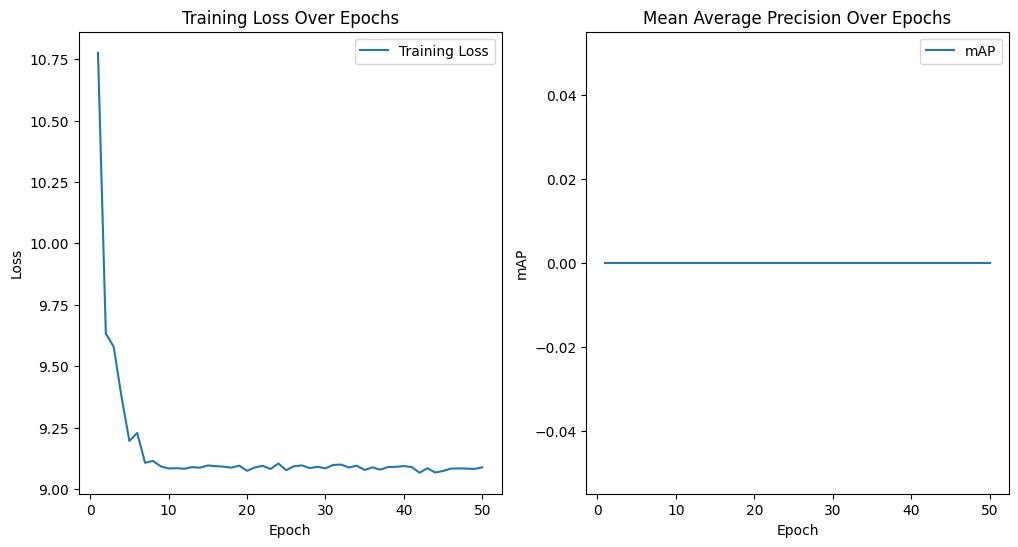

In [30]:
def get_transform():
    def transform(sample):
        spectrum = sample['spectrum']
        image = sample['image']
        objects = sample['objects']
        
        # Convert the image to a tensor but it won't be used in training
        image = F.to_tensor(image)
        return {'spectrum': spectrum, 'image': image, 'objects': objects}
    
    return transform

# Function to check if bounding box is valid
def is_valid_bbox(bbox):
    ymin, xmin, ymax, xmax = bbox
    return (xmax - xmin) > 0 and (ymax - ymin) > 0

# Assuming Lazy_RaddetDataset is defined elsewhere
train_dataset = Lazy_RaddetDataset(train_RAD_paths, train_GT_paths, train_stereo_paths, transform=get_transform())
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

test_dataset = Lazy_RaddetDataset(test_RAD_paths, test_GT_paths, test_stereo_paths, transform=get_transform())
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

# Function to get the model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Number of classes
num_classes = len(train_dataset.classes_list) + 1
model = get_model(num_classes)
model.to(device)

# Optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)  # Reduced learning rate
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Lists to store metrics
train_losses = []
mAP_scores = []

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    iteration = 0
    for batch in train_loader:
        optimizer.zero_grad()
        
        # Get the spectrum and objects from the batch
        spectra = [sample['spectrum'] for sample in batch]
        targets = [sample['objects'] for sample in batch]
        
        # Prepare the input and target format for the model
        inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]
        formatted_targets = []
        for t in targets:
            boxes = torch.tensor([obj['bbox'] for obj in t if is_valid_bbox(obj['bbox'])]).to(device)
            labels = torch.tensor([obj['label'] for obj in t if is_valid_bbox(obj['bbox'])]).to(device)
            formatted_targets.append({'boxes': boxes, 'labels': labels})
        
        loss_dict = model(inputs, formatted_targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Check for NaN loss values
        if not torch.isfinite(losses):
            print(f"Non-finite loss detected at iteration {iteration}, skipping update")
            continue
        
        losses.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        optimizer.step()
        
        epoch_loss += losses.item()
        if iteration % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{iteration}], Loss: {losses.item():.4f}")
        
        iteration += 1
    
    lr_scheduler.step()
    
    # Store epoch loss
    train_losses.append(epoch_loss / len(train_loader))

    # Calculate mAP for the test set
    model.eval()
    all_gts = {label: [] for label in range(num_classes)}
    all_preds = {label: [] for label in range(num_classes)}
    with torch.no_grad():
        for batch in test_loader:
            spectra = [sample['spectrum'] for sample in batch]
            targets = [sample['objects'] for sample in batch]
            
            inputs = [torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).to(device) for spectrum in spectra]
            formatted_targets = []
            for t in targets:
                boxes = torch.tensor([obj['bbox'] for obj in t if is_valid_bbox(obj['bbox'])]).to(device)
                labels = torch.tensor([obj['label'] for obj in t if is_valid_bbox(obj['bbox'])]).to(device)
                formatted_targets.append({'boxes': boxes, 'labels': labels})
            
            outputs = model(inputs)
            for i, output in enumerate(outputs):
                for label in range(num_classes):
                    preds = output['scores'][output['labels'] == label].cpu().numpy()
                    gts = (formatted_targets[i]['labels'] == label).cpu().numpy()
                    if preds.size > 0:
                        all_preds[label].extend(preds)
                    if gts.size > 0:
                        all_gts[label].extend(gts)

    # Compute mean average precision for each class
    aps = []
    for label in range(num_classes):
        if len(all_gts[label]) == 0 or len(all_preds[label]) == 0:
            continue
        try:
            aps.append(average_precision_score(all_gts[label], all_preds[label]))
        except ValueError as e:
            print(f"Skipping label {label} due to error: {e}")

    # Compute mean average precision
    mAP = np.mean(aps) if aps else 0.0
    mAP_scores.append(mAP)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed with mAP: {mAP:.4f}")

print("Training completed")

# Plotting the metrics
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mAP_scores, label='mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Mean Average Precision Over Epochs')
plt.legend()

plt.show()


Detected objects:


/tmp/ipykernel_2737730/2668375672.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(spectrum, dtype=torch.float32).to(device)


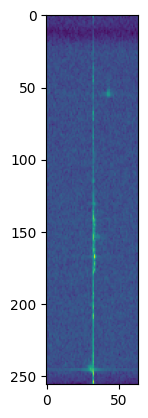

In [32]:
def infer_single_sample(model, sample, device):
    model.eval()
    with torch.no_grad():
        # Prepare the input
        spectrum = sample['spectrum']
        
        # Convert spectrum to tensor and ensure it has shape [C, H, W]
        input_tensor = torch.tensor(spectrum, dtype=torch.float32).to(device)
        if input_tensor.dim() == 2:  # If spectrum is [H, W], add a channel dimension
            input_tensor = input_tensor.unsqueeze(0)  # [1, H, W]
        if input_tensor.dim() == 3 and input_tensor.shape[0] != 3:
            input_tensor = input_tensor.repeat(3, 1, 1)  # Repeat to make [3, H, W]

        # Perform inference
        outputs = model([input_tensor])
        
        # Extract results
        output = outputs[0]
        boxes = output['boxes'].cpu().numpy()
        labels = output['labels'].cpu().numpy()
        scores = output['scores'].cpu().numpy()
        
        return boxes, labels, scores

boxes, labels, scores = infer_single_sample(model, sample, device)

# Print results
print("Detected objects:")
for box, label, score in zip(boxes, labels, scores):
    print(f"Label: {label}, Score: {score:.4f}, Box: {box}")

# Visualize the results (optional, if you have image data to show bounding boxes)
def visualize_detection(sample, boxes, labels, scores, threshold=0.5):
    image = sample['spectrum']
    # Convert image to numpy array and transpose to [H, W, C] for visualization
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    if image.shape[0] == 3:  # Assuming image is in [C, H, W] format
        image = image.transpose(1, 2, 0)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(xmin, ymin, f'{label}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()

# Visualize the detection results
visualize_detection(sample, boxes, labels, scores)


### Faster R-CNN Inference

/tmp/ipykernel_2737730/2900235444.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum_tensor = torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, 256, 64]


[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]
Raw boxes: []
Raw labels: []
Raw scores: []
Filtered boxes: []
Filtered labels: []
Filtered scores: []


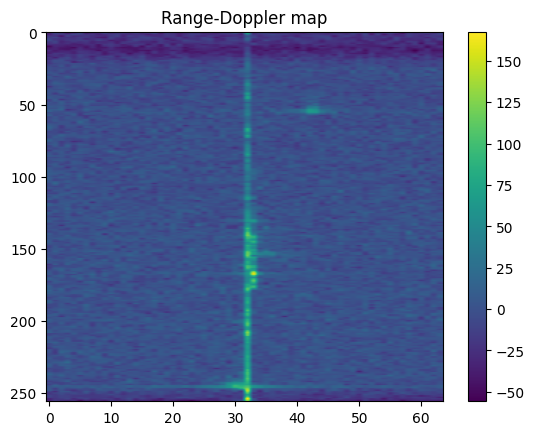

In [33]:
model.eval()
def prepare_spectrum(spectrum):
    spectrum_tensor = torch.tensor(spectrum, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # Shape: [1, 1, 256, 64]
    return spectrum_tensor

def process_predictions(predictions, score_threshold=0):
    prediction = predictions[0]
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    print("Raw boxes:", boxes)
    print("Raw labels:", labels)
    print("Raw scores:", scores)
    
    filtered_boxes = boxes[scores >= score_threshold]
    filtered_labels = labels[scores >= score_threshold]
    filtered_scores = scores[scores >= score_threshold]
    
    print("Filtered boxes:", filtered_boxes)
    print("Filtered labels:", filtered_labels)
    print("Filtered scores:", filtered_scores)
    
    return filtered_boxes, filtered_labels, filtered_scores

def visualize_spectrum_predictions(spectrum, boxes, labels, scores):
    plt.imshow(spectrum, aspect='auto', cmap='viridis')
    plt.title('Range-Doppler map')
    plt.colorbar()
    
    ax = plt.gca()
    for box, label, score in zip(boxes, labels, scores):
        ymin, xmin, ymax, xmax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'{label}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.show()
spectrum_tensor = prepare_spectrum(sample['spectrum'])

with torch.no_grad():
    predictions = model(spectrum_tensor)
print(predictions)
boxes, labels, scores = process_predictions(predictions)
visualize_spectrum_predictions(sample['spectrum'].numpy(), boxes, labels, scores)


### DETR Training

In [34]:
train_dataset = DETR_RaddetDataset(train_RAD_paths, train_GT_paths, train_stereo_paths)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

# Load the DETR model
model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, batch in enumerate(train_loader):
        spectrums = torch.stack([item['spectrum'].to(device) for item in batch])
        targets = []
        
        for item in batch:
            target = {
                'boxes': torch.tensor([obj['bbox'] for obj in item['objects']], dtype=torch.float32).to(device),
                'class_labels': torch.tensor([obj['label'] for obj in item['objects']], dtype=torch.int64).to(device),
            }
            targets.append(target)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=spectrums, labels=targets)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {epoch_loss / len(train_loader):.4f}")

print("Training completed.")



Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting epoch 1/3
Epoch [1/3], Step [10/254], Loss: 1530.0646
Epoch [1/3], Step [20/254], Loss: 1652.9003
Epoch [1/3], Step [30/254], Loss: 1596.9244
Epoch [1/3], Step [40/254], Loss: 1683.3191
Epoch [1/3], Step [50/254], Loss: 1640.7330
Epoch [1/3], Step [60/254], Loss: 1698.7085
Epoch [1/3], Step [70/254], Loss: 1655.0735
Epoch [1/3], Step [80/254], Loss: 1616.4984
Epoch [1/3], Step [90/254], Loss: 1636.2805
Epoch [1/3], Step [100/254], Loss: 1650.1993
Epoch [1/3], Step [110/254], Loss: 1702.7955
Epoch [1/3], Step [120/254], Loss: 1557.6945
Epoch [1/3], Step [130/254], Loss: 1609.0830
Epoch [1/3], Step [140/254], Loss: 1637.3822
Epoch [1/3], Step [150/254], Loss: 1610.0347
Epoch [1/3], Step [160/254], Loss: 1644.4908
Epoch [1/3], Step [170/254], Loss: 1572.4785
Epoch [1/3], Step [180/254], Loss: 1618.5525
Epoch [1/3], Step [190/254], Loss: 1591.1940
Epoch [1/3], Step [200/254], Loss: 1694.2001
Epoch [1/3], Step [210/254], Loss: 1644.9130
Epoch [1/3], Step [220/254], Loss: 1649.8434


### DETR Inference

Boxes: [[6.3975086e+01 2.5580130e+02 6.3923058e+01 2.5599637e+02]
 [8.9395367e-02 2.5581133e+02 6.3983913e+01 2.5598651e+02]
 [6.3965092e+01 2.5565047e+02 6.3972385e+01 2.5599963e+02]
 [7.4522249e-02 2.5540514e+02 6.3859310e+01 2.5599991e+02]
 [6.3966267e+01 2.5587439e+02 6.3998405e+01 2.5598828e+02]]
Scores: [0.51164097 0.7530086  0.5995233  0.81214136 0.5652208 ]
Labels: [0 2 0 2 5]
Target size: torch.Size([256, 64])
Number of detections: 5
Detection 0: Box=[ 63.975086 255.8013    63.923058 255.99637 ], Score=0.5116409659385681, Label=0
Detection 1: Box=[8.9395367e-02 2.5581133e+02 6.3983913e+01 2.5598651e+02], Score=0.7530086040496826, Label=2
Detection 2: Box=[ 63.96509  255.65047   63.972385 255.99963 ], Score=0.5995233058929443, Label=0
Detection 3: Box=[7.4522249e-02 2.5540514e+02 6.3859310e+01 2.5599991e+02], Score=0.8121413588523865, Label=2
Detection 4: Box=[ 63.966267 255.87439   63.998405 255.98828 ], Score=0.5652207732200623, Label=5


/tmp/ipykernel_2737730/2765863725.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum_3ch = torch.tensor(spectrum_data, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)


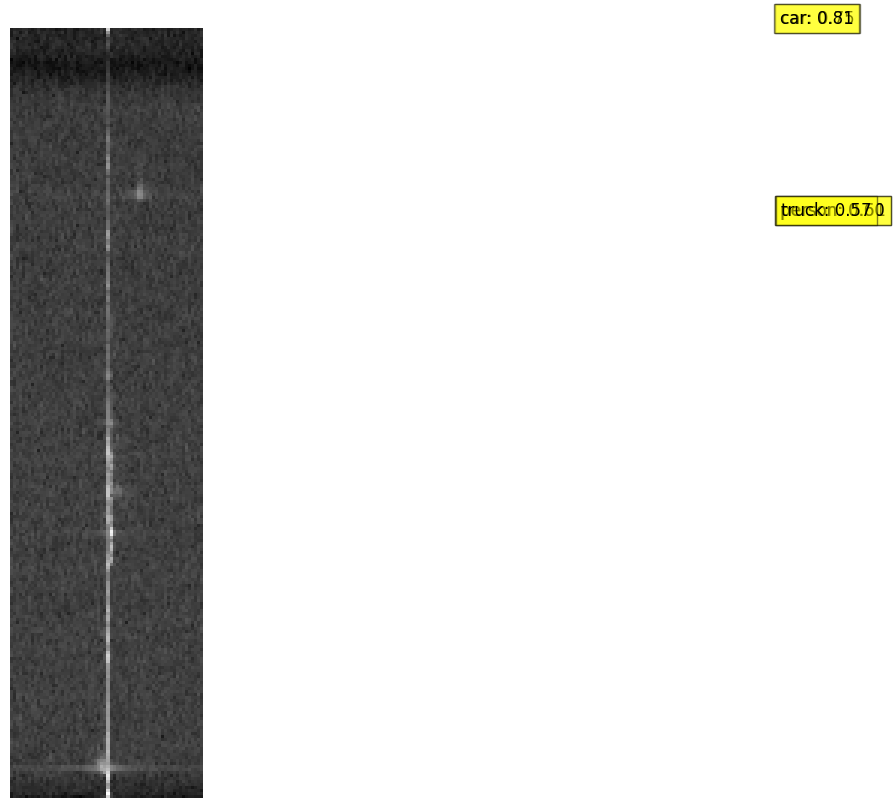

In [36]:
def post_process_detr_outputs(outputs, target_size, threshold=0.5):
    # Apply softmax to logits to get class probabilities
    probs = outputs.logits.softmax(-1)[0, :, :-1]  # Exclude the last class (background)
    scores, labels = probs.max(-1)

    # Filter boxes based on score threshold
    keep = scores > threshold
    scores = scores[keep]
    labels = labels[keep]
    boxes = outputs.pred_boxes[0, keep]

    # Scale boxes to original image size
    img_h, img_w = target_size
    scale_fct = torch.tensor([img_w, img_h, img_w, img_h]).to(boxes.device)
    boxes = boxes * scale_fct

    return boxes, scores, labels

def infer_spectrum(model, spectrum_data, target_size, threshold=0.5):
    # Prepare the spectrum data
    spectrum_3ch = torch.tensor(spectrum_data, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(pixel_values=spectrum_3ch)
    
    # Post-process the outputs
    boxes, scores, labels = post_process_detr_outputs(outputs, target_size, threshold)
    
    return boxes.cpu().numpy(), scores.cpu().numpy(), labels.cpu().numpy()

def plot_results(spectrum_data, boxes, scores, labels, classes_list, score_threshold=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(spectrum_data, cmap='gray')
    
    for box, score, label in zip(boxes, scores, labels):
        if score > score_threshold and label < len(classes_list):
            ymin, xmin, ymax, xmax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                              fill=False, edgecolor='red', linewidth=2))
            plt.text(xmin, ymin - 2, f'{classes_list[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')

    plt.axis('off')
    plt.show()

# Load a new spectrum data sample (replace with your data loading method)
new_spectrum_data = sample['spectrum']


# Define the target size (height, width)
target_size = new_spectrum_data.shape

# Run inference
boxes, scores, labels = infer_spectrum(model, new_spectrum_data, target_size)

# Print the results
print("Boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)

# Debugging: Print shapes and values to diagnose issues
print(f"Target size: {target_size}")
print(f"Number of detections: {len(boxes)}")
for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    print(f"Detection {i}: Box={box}, Score={score}, Label={label}")

# Visualize the results
plot_results(new_spectrum_data, boxes, scores, labels, train_dataset.classes_list)


In [41]:
def plot_results(spectrum_data, boxes, scores, labels, classes_list, gt_boxes=None, gt_labels=None, score_threshold=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(spectrum_data, cmap='gray')

    # Plot predicted boxes
    for box, score, label in zip(boxes, scores, labels):
        if score > score_threshold and label < len(classes_list):
            ymin, xmin, ymax, xmax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                              fill=False, edgecolor='red', linewidth=2))
            plt.text(xmin, ymin - 2, f'{classes_list[label]}: {score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5), fontsize=12, color='black')
    
    # Plot ground truth boxes
    if gt_boxes is not None and gt_labels is not None:
        for box, label in zip(gt_boxes, gt_labels):
            ymin, xmin, ymax, xmax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                              fill=False, edgecolor='blue', linewidth=2))
            plt.text(xmin, ymax + 2, f'{classes_list[label]} (GT)', bbox=dict(facecolor='cyan', alpha=0.5), fontsize=12, color='black')

    plt.axis('off')
    plt.show()

# Assuming you have the ground truth boxes and labels for the sample
gt_boxes = [obj['bbox'] for obj in sample['objects']]
gt_labels = [obj['label'] for obj in sample['objects']]

# Run inference
boxes, scores, labels = infer_spectrum(model, new_spectrum_data, target_size)

# Print the results
print("Boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)

# Debugging: Print shapes and values to diagnose issues
print(f"Target size: {target_size}")
print(f"Number of detections: {len(boxes)}")
for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    print(f"Detection {i}: Box={box}, Score={score}, Label={label}")

# Visualize the results
plot_results(new_spectrum_data, boxes, scores, labels, train_dataset.classes_list, gt_boxes, gt_labels)


ValueError: not enough values to unpack (expected 4, got 3)

Boxes: [[ 63.944546 255.7865    63.999992 256.      ]
 [ 61.714287 255.69159   63.999992 255.99915 ]
 [ 63.972874 255.54019   63.982235 256.      ]]
Scores: [0.6886874  0.78857666 0.654062  ]
Labels: [2 2 2]
Target size: torch.Size([256, 64])
Number of detections: 3
Detection 0: Box=[ 63.944546 255.7865    63.999992 256.      ], Score=0.6886873841285706, Label=2
Detection 1: Box=[ 61.714287 255.69159   63.999992 255.99915 ], Score=0.7885766625404358, Label=2
Detection 2: Box=[ 63.972874 255.54019   63.982235 256.      ], Score=0.6540619730949402, Label=2


/tmp/ipykernel_2737730/134889959.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum_3ch = torch.tensor(spectrum_data, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)


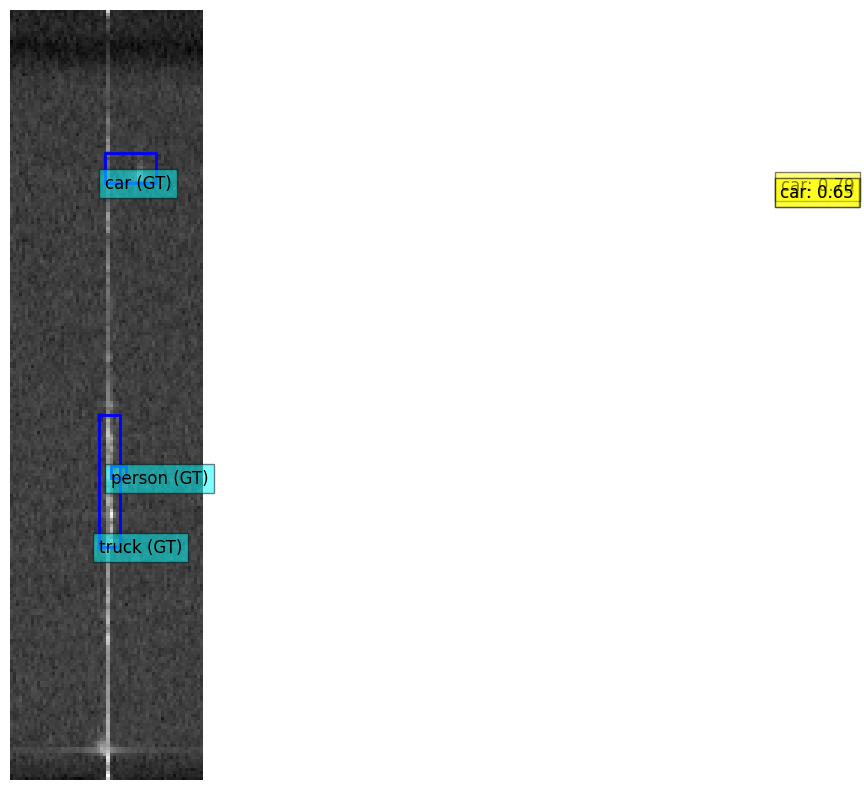

In [42]:
def infer_spectrum(model, spectrum_data, target_size, threshold=0.5):
    # Prepare the spectrum data
    spectrum_3ch = torch.tensor(spectrum_data, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
    
    # Ensure the input tensor has shape (batch_size, num_channels, height, width)
    spectrum_3ch = spectrum_3ch.unsqueeze(0) if spectrum_3ch.dim() == 3 else spectrum_3ch
    
    # Perform inference
    with torch.no_grad():
        outputs = model(pixel_values=spectrum_3ch)
    
    # Post-process the outputs
    boxes, scores, labels = post_process_detr_outputs(outputs, target_size, threshold)
    
    return boxes.cpu().numpy(), scores.cpu().numpy(), labels.cpu().numpy()

# Assuming you have the ground truth boxes and labels for the sample
gt_boxes = [obj['bbox'] for obj in sample['objects']]
gt_labels = [obj['label'] for obj in sample['objects']]

# Define the target size (height, width)
target_size = new_spectrum_data.shape

# Run inference
boxes, scores, labels = infer_spectrum(model, new_spectrum_data, target_size)

# Print the results
print("Boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)

# Debugging: Print shapes and values to diagnose issues
print(f"Target size: {target_size}")
print(f"Number of detections: {len(boxes)}")
for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    print(f"Detection {i}: Box={box}, Score={score}, Label={label}")

# Visualize the results
plot_results(new_spectrum_data, boxes, scores, labels, train_dataset.classes_list, gt_boxes, gt_labels)


# Exp

In [ ]:
validation_dataset = DETR_RaddetDataset(test_RAD_paths, test_GT_paths, test_stereo_paths, transform=get_transform())
validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: x)

def evaluate_map(model, data_loader, device):
    model.eval()
    gt_boxes = []
    pred_boxes = []
    
    with torch.no_grad():
        for batch in data_loader:
            spectrums = torch.stack([item['spectrum'].to(device) for item in batch])
            targets = []
            for item in batch:
                target = {
                    'boxes': torch.tensor([obj['bbox'] for obj in item['objects']], dtype=torch.float32).to(device),
                    'class_labels': torch.tensor([obj['label'] for obj in item['objects']], dtype=torch.int64).to(device),
                }
                targets.append(target)

            outputs = model(pixel_values=spectrums)
            pred_boxes.extend(outputs.logits.tolist())
            gt_boxes.extend(targets)

    # Calculate mAP using average_precision_score from sklearn
    gt_boxes = np.array([box['boxes'].cpu().numpy() for box in gt_boxes])
    pred_boxes = np.array(pred_boxes)
    map_score = average_precision_score(gt_boxes.ravel(), pred_boxes.ravel())

    return map_score

# Initialize lists to store metrics
train_losses = []
eval_maps = []
num_epochs = 2
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Starting epoch {epoch+1}/{num_epochs}")
    
    for batch_idx, batch in enumerate(train_loader):
        spectrums = torch.stack([item['spectrum'].to(device) for item in batch])
        targets = []
        
        for item in batch:
            target = {
                'boxes': torch.tensor([obj['bbox'] for obj in item['objects']], dtype=torch.float32).to(device),
                'class_labels': torch.tensor([obj['label'] for obj in item['objects']], dtype=torch.int64).to(device),
            }
            targets.append(target)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=spectrums, labels=targets)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate average epoch loss
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    # Evaluate mAP on validation set
    eval_map = evaluate_map(model, validation_loader, device)
    eval_maps.append(eval_map)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {epoch_loss:.4f}, Validation mAP: {eval_map:.4f}")

print("Training completed.")

# Plotting the learning curves (train loss and validation mAP)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), eval_maps, label='Validation mAP')
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Starting epoch 1/2
Epoch [1/2], Step [10/254], Loss: 1642.8007
Epoch [1/2], Step [20/254], Loss: 1678.3600
Epoch [1/2], Step [30/254], Loss: 1690.0903
Epoch [1/2], Step [40/254], Loss: 1558.4734
Epoch [1/2], Step [50/254], Loss: 1670.3599
Epoch [1/2], Step [60/254], Loss: 1713.6887
Epoch [1/2], Step [70/254], Loss: 1651.9442
Epoch [1/2], Step [80/254], Loss: 1603.6871
Epoch [1/2], Step [90/254], Loss: 1601.6145
Epoch [1/2], Step [100/254], Loss: 1551.5786
Epoch [1/2], Step [110/254], Loss: 1638.4099
Epoch [1/2], Step [120/254], Loss: 1708.7651
Epoch [1/2], Step [130/254], Loss: 1648.3280
Epoch [1/2], Step [140/254], Loss: 1617.1219
Epoch [1/2], Step [150/254], Loss: 1730.9386
Epoch [1/2], Step [160/254], Loss: 1582.0636
Epoch [1/2], Step [170/254], Loss: 1603.3409
Epoch [1/2], Step [180/254], Loss: 1649.3989
Epoch [1/2], Step [190/254], Loss: 1635.8293
Epoch [1/2], Step [200/254], Loss: 1588.4691
Epoch [1/2], Step [210/254], Loss: 1579.3596
Epoch [1/2], Step [220/254], Loss: 1603.7166


KeyError: 'image'